<div class="alert alert-block alert-info">
<center> <h1> Forecast Storage Onboarding at Filecoin Network </h1> </center> <br>
<center> Master in Data Science and Advanced Analytics </center>
<center> NOVA IMS </center>

**Table of Contents** <br>

* [1.0 Import](#import)
* [2.0 Data Understanding](#data_understanding)
* [3.0 Data Preparation](#data_preparation)
* [4.0 Data Visualization](#data_visualization)
* [5.0 Times Series Understanding](#time_series)
* [6.0 Modeling and Assessment](#modeling)
  * [6.1 Performance Estimation](#estimation)
  * [6.2 Baseline Model (Linear Regression)](#baseline)
  * [6.3 ARIMA Model (Box Jenkins)](#arima)
  * [6.4 Long Short Term Memory (LSTM)](#lstm)
  * [6.5 Ensemble Learning LSTM + CNN](#ensemble)
  * [6.6 Feature Importance Analysis](#feature_importance)



<hr>
<a class="anchor" id="import">
    
# 1.0 Import
    
</a>


In [1]:
#common packages
import pandas as pd
import numpy as np
import scipy as sp
from math import ceil, pi
import os
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
from tqdm import tqdm_notebook

#dataviz
import seaborn as sns
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport
#restarting matplotlib
%matplotlib inline
plt.close('all')
sns.set()


#importing stock data from Yahoo Finance
!pip install yfinance
import yfinance as yf

#algorithms for data preparation and preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

#libs for model assessment
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_log_error



#import libs for ML modeling
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm


#Time Series and Modeling
!pip install pmdarima
from pmdarima import auto_arima
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.inspection import permutation_importance
!pip install shap
import shap

#Neural Networks
!pip install scikeras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.neural_network import MLPRegressor



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.5 MB/s eta 0:00:00


##Data Import

In [2]:
# reads the csv files to a pandas dataframe named 'df'
df = pd.read_csv('/content/drive/MyDrive/02. Master Data Science NOVA IMS/Master Thesis/Notebooks/data/storage_power2021-01-01_2023-02-20.csv', sep=',')

In [3]:
df.head()

request_id  code   message  \
0  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
1  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
2  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
3  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
4  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   

              stat_date  miner_id   raw_byte_power  quality_adj_power  
0  2021-01-01T00:00:00Z  f0100066                0                  0  
1  2021-01-01T00:00:00Z   f010048   66005057404928     66005057404928  
2  2021-01-01T00:00:00Z   f010038   82841329205248     82841329205248  
3  2021-01-01T00:00:00Z  f0100082  476810089332736    476810089332736  
4  2021-01-01T00:00:00Z   f010088   72086731096064     72086731096064

In [4]:
#checks the min() and max() stat_date
print(df['stat_date'].min() , df['stat_date'].max())

2021-01-01T00:00:00Z 2023-02-20T00:00:00Z


In [5]:
# Defines the date parameters to retrieve historical data
start_date = "2021-01-01"
end_date = "2023-02-21"

#imports historical data from Filecoint using yahoo Finance API
fil_data = yf.download('FIL-USD', start= start_date, end= end_date, interval='1d')

#resets the datafram index
fil_data = fil_data.reset_index()

#converts all the features to lower case
fil_data = fil_data.rename(columns=lambda x: x.lower())

#checks the df header
fil_data.head()

[*********************100%%**********************]  1 of 1 completed


date       open       high        low      close  adj close     volume
0 2021-01-01  24.359148  24.958113  22.023264  22.291010  22.291010  348030664
1 2021-01-02  22.288815  23.133966  21.432627  21.808891  21.808891  243646888
2 2021-01-03  21.817991  21.873875  21.029001  21.426378  21.426378  272432560
3 2021-01-04  21.434067  22.923031  21.011490  21.467407  21.467407  312309245
4 2021-01-05  21.428017  22.291952  21.060802  21.632771  21.632771  213135095

In [6]:
#checks the min() and max() Date in Fil dataset
print(fil_data['date'].min() , fil_data['date'].max())

2021-01-01 00:00:00 2023-02-20 00:00:00


<hr>
<a class="anchor" id="data_understanding">
    
## 2.0 Data Understanding
    
</a>

**EDA of fil_data dataset obtained from Yfinance API**

In [ ]:
#checks if there are null values in the dataset
fil_data.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj close    0
volume       0
dtype: int64

In [ ]:
#checks general info of the dataset
fil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       781 non-null    datetime64[ns]
 1   open       781 non-null    float64       
 2   high       781 non-null    float64       
 3   low        781 non-null    float64       
 4   close      781 non-null    float64       
 5   adj close  781 non-null    float64       
 6   volume     781 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 42.8 KB


In [ ]:
#describes the main statistics
fil_data.describe()

open        high         low       close   adj close  \
count  781.000000  781.000000  781.000000  781.000000  781.000000   
mean    38.202910   40.060254   36.288813   38.175546   38.175546   
std     40.325964   42.718962   38.108268   40.346698   40.346698   
min      2.808193    2.965434    2.678534    2.806761    2.806761   
25%      5.829846    6.039844    5.617069    5.830133    5.830133   
50%     22.016642   22.752178   21.381483   21.969751   21.969751   
75%     59.053757   62.673992   56.035103   59.123135   59.123135   
max    191.153915  237.241821  182.714111  191.356552  191.356552   

             volume  
count  7.810000e+02  
mean   6.986412e+08  
std    9.618457e+08  
min    4.127013e+07  
25%    2.052785e+08  
50%    3.906103e+08  
75%    8.123473e+08  
max    1.236798e+10

In [ ]:
#checks duplicates in the dataset
fil_data.duplicated().sum()

0

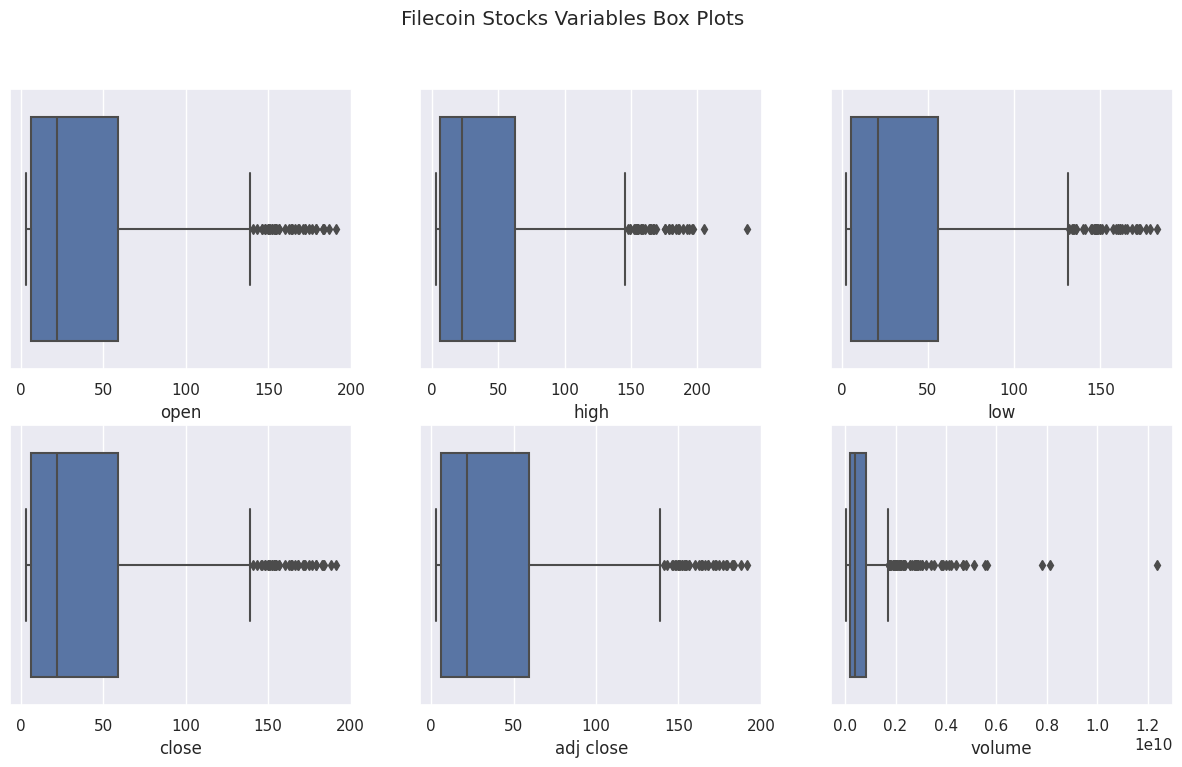

In [ ]:
# All Numeric Variables' Box Plots in one figure
sns.set()

metric_feat = fil_data.columns.drop('date').to_list()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(15, 8))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=fil_data[feat], ax=ax)

# Layout
# Add a centered title to the figure:
title = "Filecoin Stocks Variables Box Plots"

plt.suptitle(title)

plt.show()

In [ ]:
# All Numeric Variables' Histograms in one figure
sns.set()

metric_feat = fil_data.columns.drop('date').to_list()

fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(15, 10))

for ax, feat in zip(axes.flatten(), metric_feat):
    ax.hist(fil_data[feat])
    ax.set_title(feat, y=-0.13)

title = "Filecoin Stocks Variables' Histograms"

plt.suptitle(title)
plt.show()

##EDA of Storage Onboarding data obtained from API Spacescope

In [ ]:
#describes the main statistics from the dataset
df.describe()

code  raw_byte_power  quality_adj_power
count  3366761.0    3.366761e+06       3.366761e+06
mean         0.0    3.209079e+15       3.453804e+15
std          0.0    9.016948e+15       9.189112e+15
min          0.0    0.000000e+00       0.000000e+00
25%          0.0    2.164664e+12       2.404095e+12
50%          0.0    5.707840e+14       6.816972e+14
75%          0.0    2.595122e+15       2.943828e+15
max          0.0    1.790324e+17       1.790324e+17

In [ ]:
#shows the general information from the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366761 entries, 0 to 3366760
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   request_id         object
 1   code               int64 
 2   message            object
 3   stat_date          object
 4   miner_id           object
 5   raw_byte_power     int64 
 6   quality_adj_power  int64 
dtypes: int64(3), object(4)
memory usage: 179.8+ MB


In [ ]:
#sums up the number os null observations
df.isna().sum()

request_id           0
code                 0
message              0
stat_date            0
miner_id             0
raw_byte_power       0
quality_adj_power    0
dtype: int64

In [ ]:
#brings the duplicated observations, if exists
df.duplicated().sum()

0

In [ ]:
#checks the unique codes
df['code'].unique()

array([0])

In [ ]:
#checks the unique messages
df['message'].unique()

array(['success.'], dtype=object)

In [ ]:
#checks the amount of records for each miner_id
df.groupby('miner_id')['request_id'].count().sort_values(ascending=False)

miner_id
f0100033     781
f024148      781
f02401       781
f024012      781
f024013      781
            ... 
f02032191      3
f02038992      3
f01927170      3
f02038720      2
f02041586      1
Name: request_id, Length: 6001, dtype: int64

In [ ]:
df.head()

request_id  code   message  \
0  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
1  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
2  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
3  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   
4  807410cd-217e-43dc-9cef-8b2b76f5e743#1010033     0  success.   

              stat_date  miner_id   raw_byte_power  quality_adj_power  
0  2021-01-01T00:00:00Z  f0100066                0                  0  
1  2021-01-01T00:00:00Z   f010048   66005057404928     66005057404928  
2  2021-01-01T00:00:00Z   f010038   82841329205248     82841329205248  
3  2021-01-01T00:00:00Z  f0100082  476810089332736    476810089332736  
4  2021-01-01T00:00:00Z   f010088   72086731096064     72086731096064

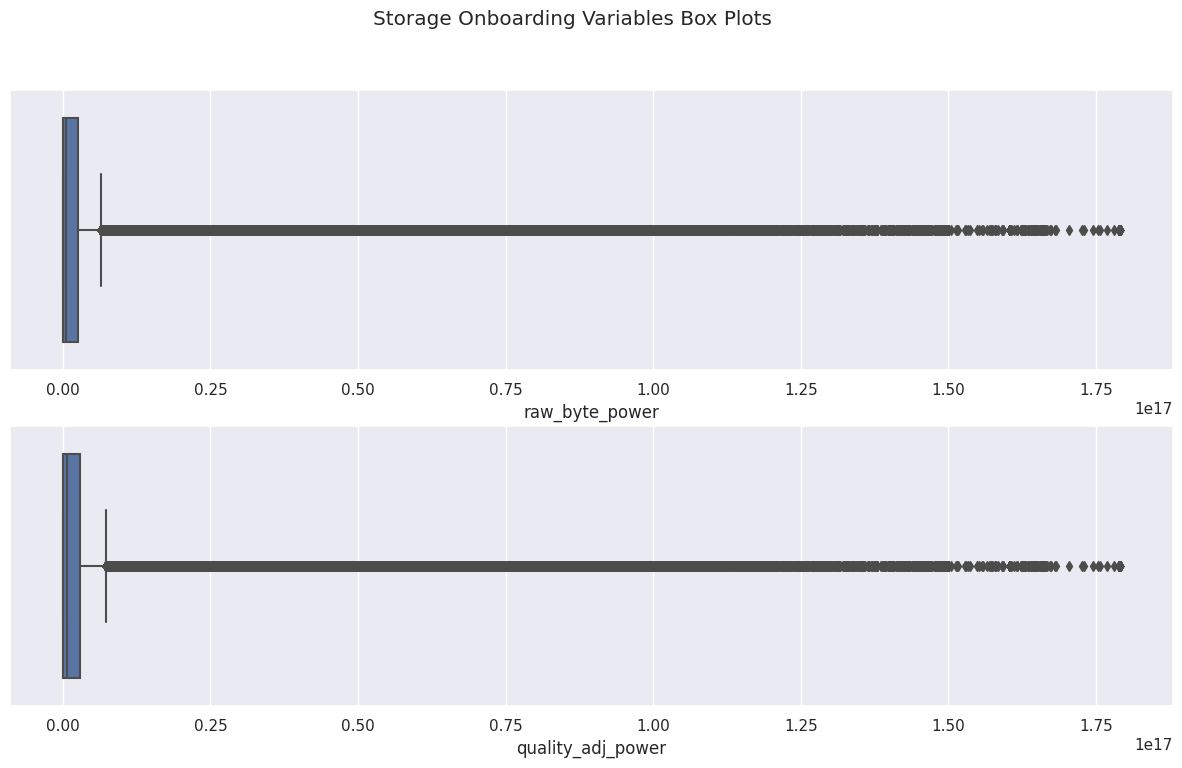

In [ ]:
# All Numeric Variables' Box Plots in one figure
sns.set()

metric_feat = df.columns.drop(['code', 'message', 'stat_date', 'request_id', 'miner_id']).to_list()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(15, 8))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)

# Layout
# Add a centered title to the figure:
title = "Storage Onboarding Variables Box Plots"

plt.suptitle(title)

plt.show()

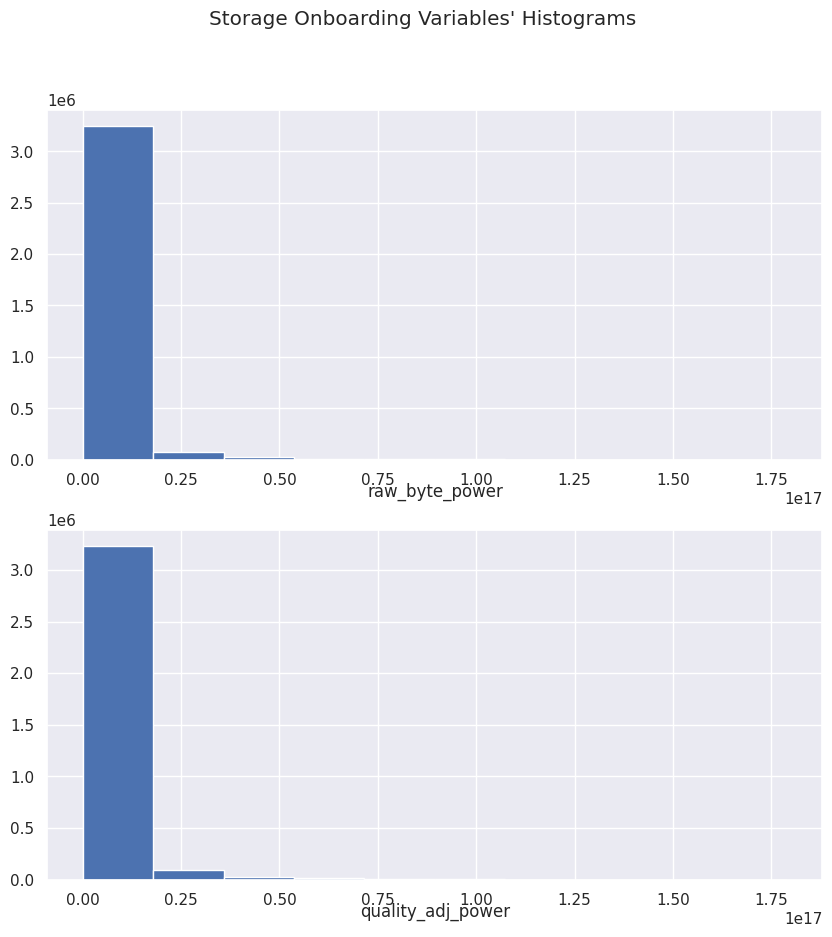

In [ ]:
# All Numeric Variables' Histograms in one figure
sns.set()

metric_feat = df.columns.drop(['code', 'message', 'stat_date', 'request_id', 'miner_id']).to_list()

fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(10, 10))

for ax, feat in zip(axes.flatten(), metric_feat):
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)

title = "Storage Onboarding Variables' Histograms"

plt.suptitle(title)
plt.show()

### Notes:

<hr>
<a class="anchor" id="data_preparation">
    
# 3.0 Data Preparation
    
</a>

In [7]:
#creates a copy from df
df_prep = df.copy()

#deletes the columns with no relevant information
df_prep = df_prep.drop(columns=['request_id', 'code', 'message'])

# converts the units from bytes to terabytes
df_prep['peta_raw_power'] = df_prep['raw_byte_power'] / 1000000000000000 #convert bytes to terabytes
df_prep['peta_quality_power'] = df_prep['quality_adj_power'] / 1000000000000000


# creates a dataframe aggregating the numeric metrics
df_agg = df_prep.groupby('stat_date').agg({'miner_id': 'nunique',
                                           'raw_byte_power': 'sum',
                                           'peta_raw_power': 'sum',
                                           'peta_quality_power': 'sum',
                                           'quality_adj_power': 'sum'}).reset_index()

#renames column miner_id
df_storage = df_agg.rename(columns={'miner_id': 'unique_miners', 'stat_date':'date'})

#show df header
df_storage

date  unique_miners       raw_byte_power  peta_raw_power  \
0    2021-01-01T00:00:00Z           1363  1930034745203228914     1930.034745   
1    2021-01-02T00:00:00Z           1371  1951233466825703514     1951.233467   
2    2021-01-03T00:00:00Z           1379  1971092158651826094     1971.092159   
3    2021-01-04T00:00:00Z           1381  1987660012176014994     1987.660012   
4    2021-01-05T00:00:00Z           1388  2007411467258692010     2007.411467   
..                    ...            ...                  ...             ...   
776  2023-02-16T00:00:00Z           5989 -2735280021588411262    15711.464052   
777  2023-02-17T00:00:00Z           5992 -2762668134681805314    15684.075939   
778  2023-02-18T00:00:00Z           5999 -2718197081226346726    15728.546992   
779  2023-02-19T00:00:00Z           6000 -2731879300843175326    15714.864773   
780  2023-02-20T00:00:00Z           6001 -2747677839825305284    15699.066234   

     peta_quality_power    quality_adj_power  
0           1930.161061  1930161061394284754  
1           1951.369219  1951369219415769126  
2           1971.236994  1971236994144763880  
3           1987.820845  1987820844927843944  
4           2007.595646  2007595645735764356  
..                  ...                  ...  
776        21643.871842  3197127768332532458  
777        21649.922075  3203178001000201480  
778        21743.156862  3296412788493680236  
779        21760.277110  3313533036315049914  
780        21757.026713  3310282639667396812  

[781 rows x 6 columns]

In [8]:
#converts the date to type datetime
df_storage['date'] = pd.to_datetime(df_storage['date'], format='%Y-%m-%d')

#removes the “00:00:00+00:00” in the date field
df_storage['date'] = df_storage['date'].dt.date

#show df header
df_storage.head()

date  unique_miners       raw_byte_power  peta_raw_power  \
0  2021-01-01           1363  1930034745203228914     1930.034745   
1  2021-01-02           1371  1951233466825703514     1951.233467   
2  2021-01-03           1379  1971092158651826094     1971.092159   
3  2021-01-04           1381  1987660012176014994     1987.660012   
4  2021-01-05           1388  2007411467258692010     2007.411467   

   peta_quality_power    quality_adj_power  
0         1930.161061  1930161061394284754  
1         1951.369219  1951369219415769126  
2         1971.236994  1971236994144763880  
3         1987.820845  1987820844927843944  
4         2007.595646  2007595645735764356

In [9]:
#creates a copy from fil_data
fil_prep = fil_data.copy()

#deletes the columns with no relevant information
fil_prep = fil_prep.drop(columns=['high', 'low', 'close','adj close'])

#renames columns
fil_prep = fil_prep.rename(columns={'open': 'open_price', 'volume':'traded_volume'})

#converts the date to type datetime
fil_prep['date'] = fil_prep['date'].dt.date

#shows the fil_prep dataset header
fil_prep.head()

date  open_price  traded_volume
0  2021-01-01   24.359148      348030664
1  2021-01-02   22.288815      243646888
2  2021-01-03   21.817991      272432560
3  2021-01-04   21.434067      312309245
4  2021-01-05   21.428017      213135095

**Merging information of daily Storage and Prices of Filecoin**

In [10]:
#merges the two dataset fil_prep and df_storage into one named df_merged
df_merged = pd.merge(fil_prep, df_storage, on='date', how='inner')

#print new dataframe
df_merged

date  open_price  traded_volume  unique_miners  \
0    2021-01-01   24.359148      348030664           1363   
1    2021-01-02   22.288815      243646888           1371   
2    2021-01-03   21.817991      272432560           1379   
3    2021-01-04   21.434067      312309245           1381   
4    2021-01-05   21.428017      213135095           1388   
..          ...         ...            ...            ...   
776  2023-02-16    5.479461      401387749           5989   
777  2023-02-17    5.398729     1539223863           5992   
778  2023-02-18    7.668670      842413279           5999   
779  2023-02-19    7.514821     1727690437           6000   
780  2023-02-20    8.444652      906160252           6001   

          raw_byte_power  peta_raw_power  peta_quality_power  \
0    1930034745203228914     1930.034745         1930.161061   
1    1951233466825703514     1951.233467         1951.369219   
2    1971092158651826094     1971.092159         1971.236994   
3    1987660012176014994     1987.660012         1987.820845   
4    2007411467258692010     2007.411467         2007.595646   
..                   ...             ...                 ...   
776 -2735280021588411262    15711.464052        21643.871842   
777 -2762668134681805314    15684.075939        21649.922075   
778 -2718197081226346726    15728.546992        21743.156862   
779 -2731879300843175326    15714.864773        21760.277110   
780 -2747677839825305284    15699.066234        21757.026713   

       quality_adj_power  
0    1930161061394284754  
1    1951369219415769126  
2    1971236994144763880  
3    1987820844927843944  
4    2007595645735764356  
..                   ...  
776  3197127768332532458  
777  3203178001000201480  
778  3296412788493680236  
779  3313533036315049914  
780  3310282639667396812  

[781 rows x 8 columns]

In [ ]:
#display.float_format', lambda x: f'{x:.3f}')

In [ ]:
#pd.reset_option('display.float_format')

In [11]:
#creates fil_plus_rate
df_merged['fil_plus_rate'] = (df_merged['peta_quality_power'] / df_merged['peta_raw_power'] - 1) / 9
df_merged.head()

date  open_price  traded_volume  unique_miners       raw_byte_power  \
0  2021-01-01   24.359148      348030664           1363  1930034745203228914   
1  2021-01-02   22.288815      243646888           1371  1951233466825703514   
2  2021-01-03   21.817991      272432560           1379  1971092158651826094   
3  2021-01-04   21.434067      312309245           1381  1987660012176014994   
4  2021-01-05   21.428017      213135095           1388  2007411467258692010   

   peta_raw_power  peta_quality_power    quality_adj_power  fil_plus_rate  
0     1930.034745         1930.161061  1930161061394284754       0.000007  
1     1951.233467         1951.369219  1951369219415769126       0.000008  
2     1971.092159         1971.236994  1971236994144763880       0.000008  
3     1987.660012         1987.820845  1987820844927843944       0.000009  
4     2007.411467         2007.595646  2007595645735764356       0.000010

In [12]:
#calculates the daily variation of Storage variables

#creates delta raw_byte_power
df_merged['delta_RBP'] = df_merged['peta_raw_power'].diff().fillna(0)

#creates delta quality_adj_power
df_merged['delta_QAP'] = df_merged['peta_quality_power'].diff().fillna(0)

#creates delta fil_plus_rate
df_merged['delta_fil_plus_rate'] = df_merged['fil_plus_rate'].diff().fillna(0)

#creates delta unique_miners
df_merged['delta_miners'] = df_merged['unique_miners'].diff().fillna(0)

df_merged.head()

date  open_price  traded_volume  unique_miners       raw_byte_power  \
0  2021-01-01   24.359148      348030664           1363  1930034745203228914   
1  2021-01-02   22.288815      243646888           1371  1951233466825703514   
2  2021-01-03   21.817991      272432560           1379  1971092158651826094   
3  2021-01-04   21.434067      312309245           1381  1987660012176014994   
4  2021-01-05   21.428017      213135095           1388  2007411467258692010   

   peta_raw_power  peta_quality_power    quality_adj_power  fil_plus_rate  \
0     1930.034745         1930.161061  1930161061394284754       0.000007   
1     1951.233467         1951.369219  1951369219415769126       0.000008   
2     1971.092159         1971.236994  1971236994144763880       0.000008   
3     1987.660012         1987.820845  1987820844927843944       0.000009   
4     2007.411467         2007.595646  2007595645735764356       0.000010   

   delta_RBP  delta_QAP  delta_fil_plus_rate  delta_miners  
0   0.000000   0.000000         0.000000e+00           0.0  
1  21.198722  21.208158         4.583422e-07           8.0  
2  19.858692  19.867775         4.341237e-07           8.0  
3  16.567854  16.583851         8.262008e-07           2.0  
4  19.751455  19.774801         1.203735e-06           7.0

In [13]:
#checks for null values
df_merged.isna().sum()

date                   0
open_price             0
traded_volume          0
unique_miners          0
raw_byte_power         0
peta_raw_power         0
peta_quality_power     0
quality_adj_power      0
fil_plus_rate          0
delta_RBP              0
delta_QAP              0
delta_fil_plus_rate    0
delta_miners           0
dtype: int64

In [13]:
#checks duplicated rows
df_merged.duplicated().sum()

0

<hr>
<a class="anchor" id="data_visualization">
    
# 4.0 Data Visualization
    
</a>

In [ ]:
# analyze Raw Byte Power and Quality Adjusted Power over time
#sets figure size
plt.figure(figsize=(10, 5))

# plots 'raw_byte_power'
sns.lineplot(x='date', y='peta_raw_power', data=df_merged, color='blue', label='Raw Byte Power (petabyte)')

# plots 'quality_adj_power'
sns.lineplot(x='date', y='peta_quality_power', data=df_merged, color='red', label='Quality Adj Power (petabyte)')

# adds a title
plt.title('Sum of Raw Byte Power and Quality Adjusted Power')

# adds labels
plt.xlabel('Stat Date')
plt.ylabel('Power')

# plots the visualization
plt.show()

In [ ]:
#Analyze Filecoin Stock Open price over time
#sets figure size
plt.figure(figsize=(10, 5))

# plots 'open price'
sns.lineplot(x='date', y='open_price', data=df_merged, color='blue', label='Fil Open Price')


# adds a title
plt.title('Filecoin Open Price (Stocks)')

# adds labels
plt.xlabel('Stat Date')
plt.ylabel('Power')

# plots the visualization
plt.show()

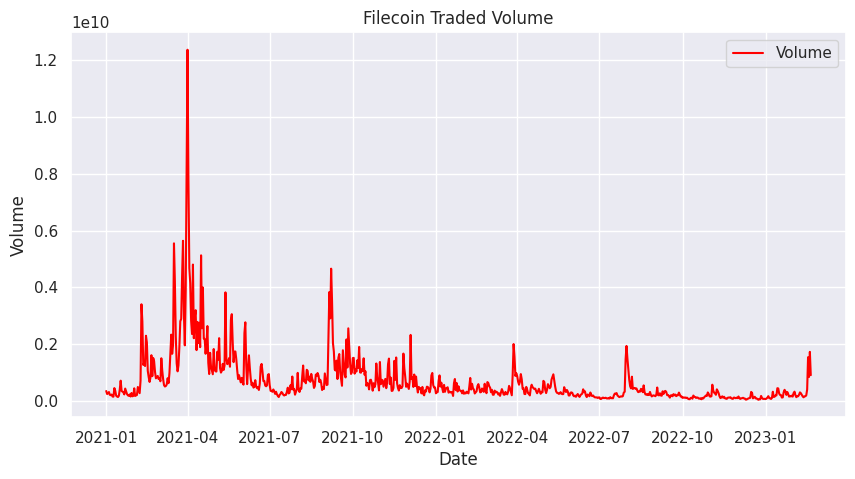

In [ ]:
#Analyze Filecoin Stock Traded Volume over time
#sets figure size
plt.figure(figsize=(10, 5))

# plots 'traded volume'
sns.lineplot(x='date', y='traded_volume', data=df_merged, color='red', label='Volume')

# adds a title
plt.title('Filecoin Traded Volume')

# adds labels
plt.xlabel('Date')
plt.ylabel('Volume')

# plots the visualization
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

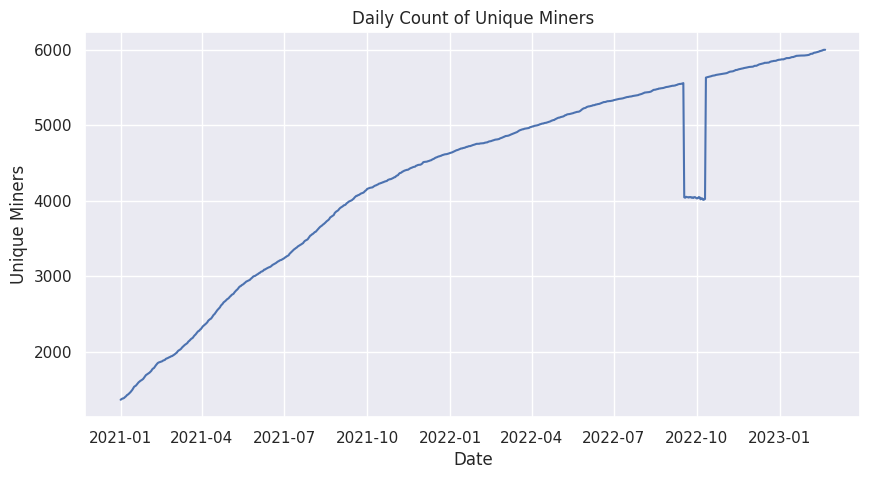

In [ ]:
#Verify the count of unique Miners (Storage Providers) over time
#sets figure size
plt.figure(figsize=(10, 5))

# creates a visualization with unique_miners in Y and date in X axis
sns.lineplot(x='date', y='unique_miners', data=df_merged)

# Names the graph
plt.title('Daily Count of Unique Miners')

# Inputs the axis labels
plt.xlabel('Date')
plt.ylabel('Unique Miners')

# Shows the visualization
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

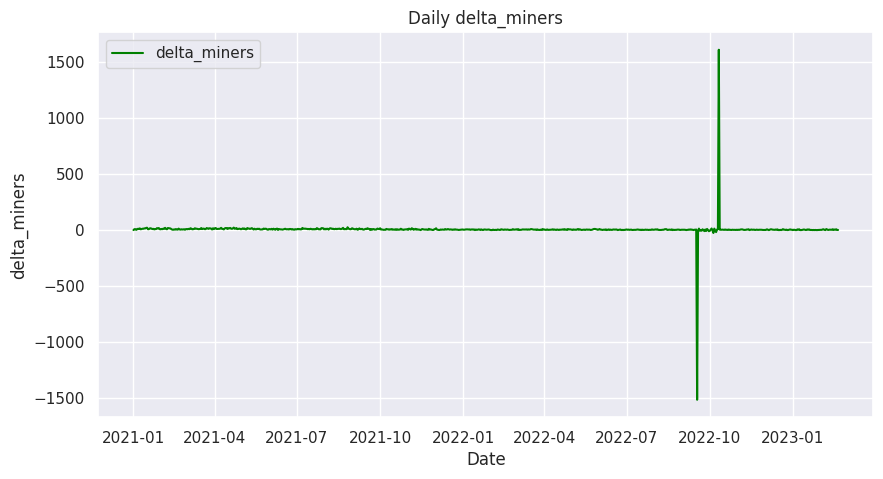

In [ ]:
#Checking the daily variation of Miners (Storage Providers)
plt.figure(figsize=(10, 5))

# creates a daily delta_miners visualization
sns.lineplot(x='date', y='delta_miners', data=df_merged, color='green', label='delta_miners')

# Names the graph
plt.title('Daily delta_miners')

# Inputs the axis labels
plt.xlabel('Date')
plt.ylabel('delta_miners')

# Shows the visualization
plt.show

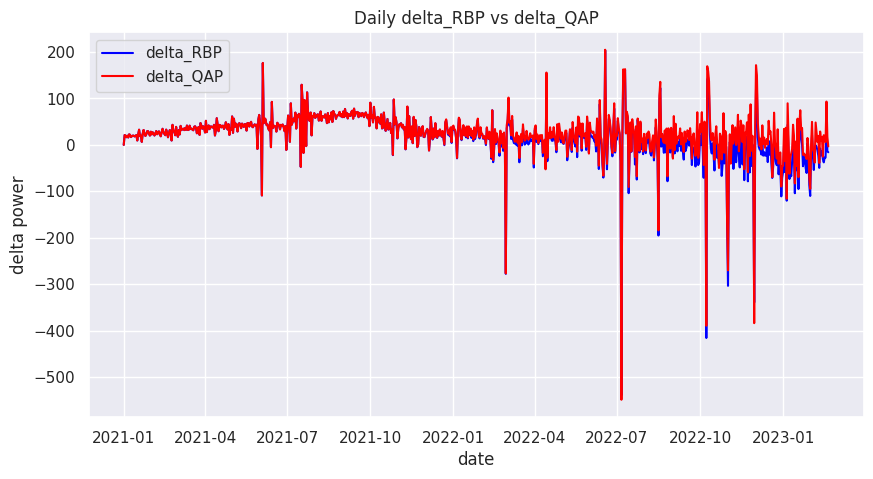

In [ ]:
#Analyze delta_RBP and delta_QAP over time

plt.figure(figsize=(10, 5))

# creates a line plot with delta_RBP as blue
sns.lineplot(x='date', y='delta_RBP', data=df_merged, color='blue', label='delta_RBP')

# creates a line plot with delta_QAP as red
sns.lineplot(x='date', y='delta_QAP', data=df_merged, color='red', label='delta_QAP')

# adds title
plt.title('Daily delta_RBP vs delta_QAP')

# adds the axis labels
plt.xlabel('date')
plt.ylabel('delta power')

# plots the visualization
plt.show()

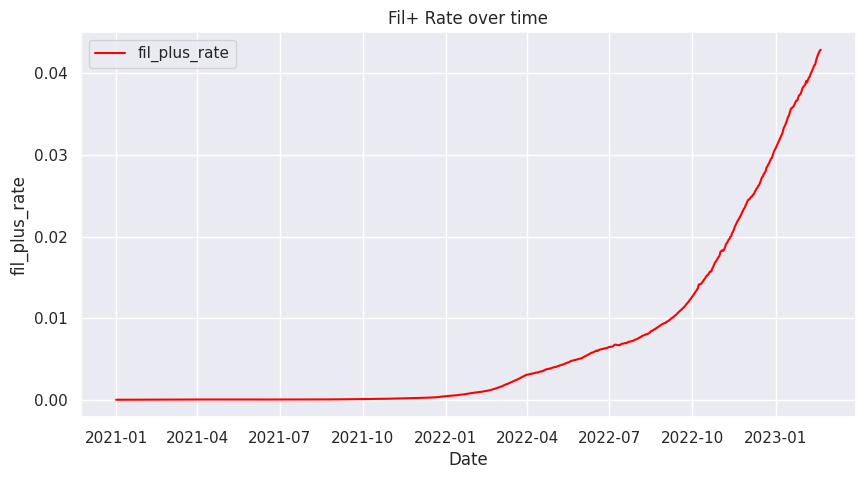

In [ ]:
#Analyze Fil_plus_rate over time

#sets figure size
plt.figure(figsize=(10, 5))

# plots 'fil_plus_rate'
sns.lineplot(x='date', y='fil_plus_rate', data=df_merged, color='red', label='fil_plus_rate')

# adds a title
plt.title('Fil+ Rate over time')

# adds labels
plt.xlabel('Date')
plt.ylabel('fil_plus_rate')

# plots the visualization
plt.show()

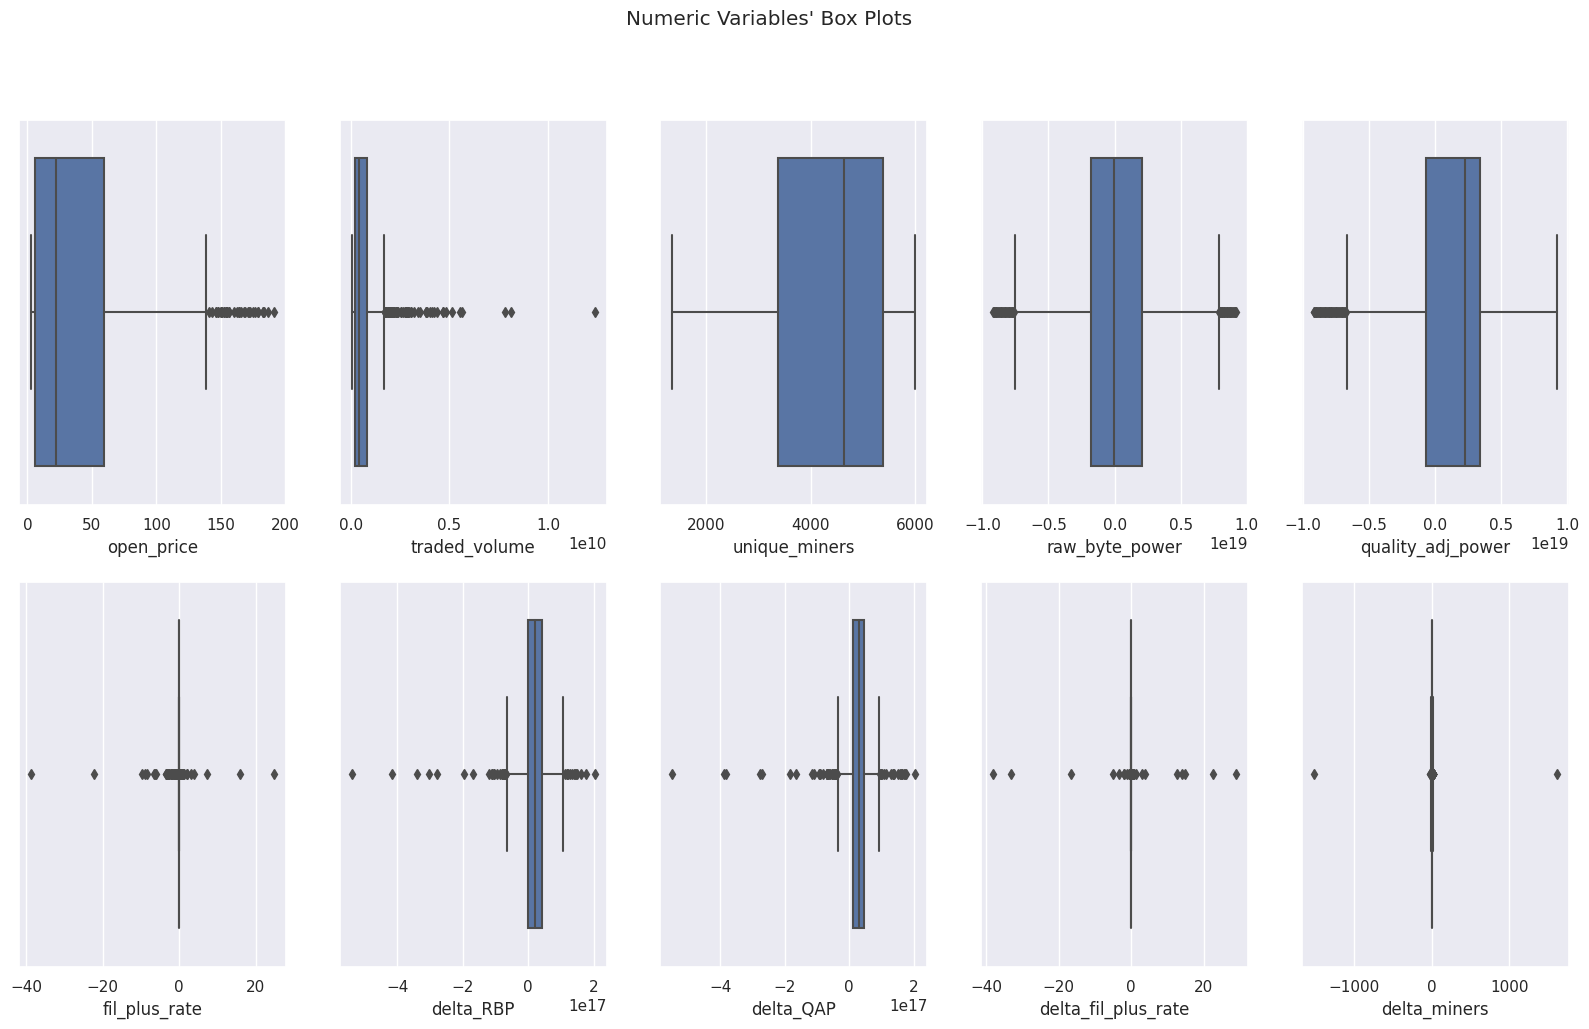

In [ ]:
#Checking the boxplot for the numeric variables in the dataset

# All Numeric Variables' Box Plots in one figure
sns.set()

metric_feat = df_merged.columns.drop('date').to_list()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_merged[feat], ax=ax)

# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

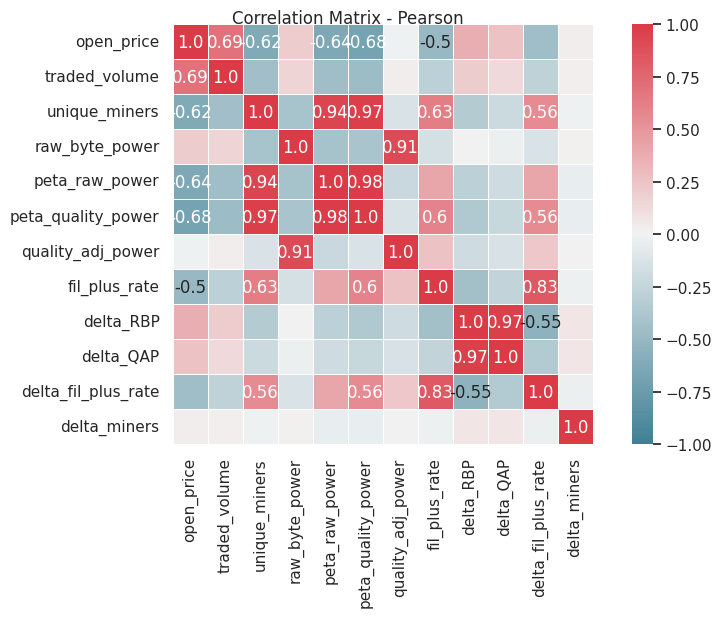

In [ ]:
#Checking the Correlation Matrix - Pearson  for the numeric variables in the dataset

# Prepare figure
fig = plt.figure(figsize=(10, 5))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_merged.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix - Pearson", fontsize=12)
plt.show()

## Outliers Diagnosis (IQR)

In [ ]:
#creating a copy of the dataset to test IQR outlier removal method
df_iqr = df_merged.copy()

In [ ]:
# Applying the technique IQR for outlier removal

metric_feat = df_merged.columns.drop('date').to_list()

q25 = df_merged.quantile(.25)
q75 = df_merged.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 3 * iqr
lower_lim = q25 - 3 * iqr

filters = []
for metric in metric_feat:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(df_iqr[metric].between(llim, ulim, inclusive=True))

df_iqr_2 = df_iqr[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(df_iqr_2.shape[0] / df_iqr.shape[0], 4))

Percentage of data kept after removing outliers: 0.8438


##Notes

<hr>
<a class="anchor" id="time_series">
    
# 5.0 Times Series Understanding
    
</a>

In [14]:
#creates a copy from df_merged
data = df_merged.copy()

In [15]:
#set date as index
data.set_index('date', inplace = True)

data.head(2)

open_price  traded_volume  unique_miners       raw_byte_power  \
date                                                                        
2021-01-01   24.359148      348030664           1363  1930034745203228914   
2021-01-02   22.288815      243646888           1371  1951233466825703514   

            peta_raw_power  peta_quality_power    quality_adj_power  \
date                                                                  
2021-01-01     1930.034745         1930.161061  1930161061394284754   
2021-01-02     1951.233467         1951.369219  1951369219415769126   

            fil_plus_rate  delta_RBP  delta_QAP  delta_fil_plus_rate  \
date                                                                   
2021-01-01       0.000007   0.000000   0.000000         0.000000e+00   
2021-01-02       0.000008  21.198722  21.208158         4.583422e-07   

            delta_miners  
date                      
2021-01-01           0.0  
2021-01-02           8.0

###Moving Average




In [ ]:
def plot_moving_average_delta_RBP(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(10,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    # adds labels
    plt.xlabel('Date')
    plt.ylabel('delta_RBP')
    plt.legend(loc='best')
    plt.grid(True)

##### Delta RBP

In [ ]:
#Smooth by the previous 5 days (by week)
plot_moving_average_delta_RBP(data.delta_RBP, 5)

In [ ]:
#Smooth by previous quarter (10 days)
plot_moving_average_delta_RBP(data.delta_RBP, 10, plot_intervals=True)

##### Delta Fil Plus Rate

In [ ]:
def plot_moving_average_fil_plus(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(10,5))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    # adds labels
    plt.xlabel('Date')
    plt.ylabel('fil_plus_rate')
    plt.legend(loc='best')
    plt.grid(True)

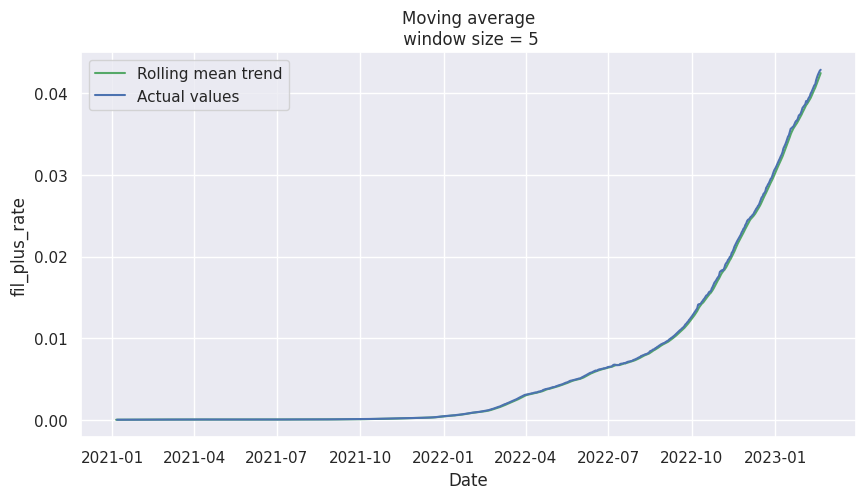

In [ ]:
#Smooth by the previous 5 days (by week)
plot_moving_average_fil_plus(data.fil_plus_rate, 5)

In [ ]:
#Smooth by previous quarter (10 days)
plot_moving_average_fil_plus(data.fil_plus_rate, 10, plot_intervals=True)

###Time Series Decomposal

####Delta RBP

In [ ]:
#Time Series Decompose for the raw_byte_power
decompose = seasonal_decompose(data.delta_RBP.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(10,5)})
f = decompose.plot()
plt.suptitle('delta_RBP', y=1.05)
plt.xlabel('Date')

plt.show()

#####  Fil Plus *Rate*

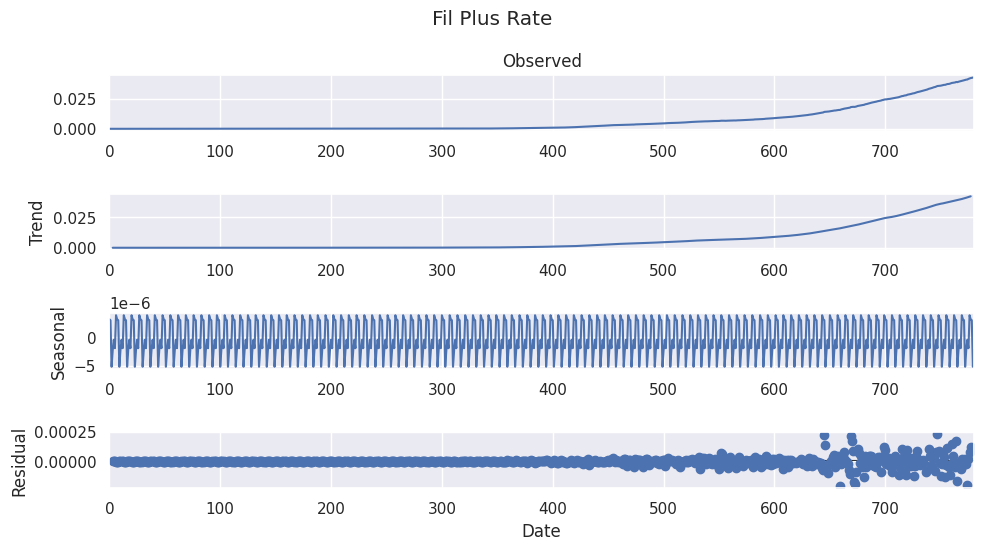

In [ ]:
#Time Series Decompose for the raw_byte_power
decompose = seasonal_decompose(data.fil_plus_rate.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(10,5)})
f = decompose.plot()
plt.suptitle('Fil Plus Rate', y=1.05)
plt.xlabel('Date')

plt.show()

### Stationarity Test

In [ ]:
def tsplot_delta_RBP(y, lags=None, figsize=(10, 5), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('delta_RBP Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


##### **Delta RBP**

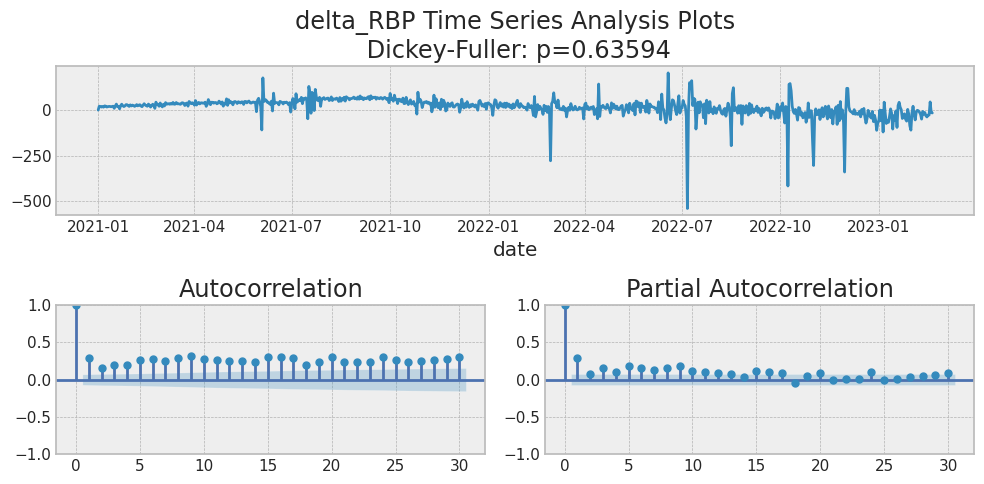

In [ ]:
#checks stationarity in Delta RBP time series
tsplot_delta_RBP(data.delta_RBP, lags=30)

In [ ]:
#checks stationarity in Delta RBP with 1 diff
data_diff = data.delta_RBP - data.delta_RBP.shift(1)

tsplot_delta_RBP(data_diff[1:], lags=30)

##### **Fil Plus Rate**

In [ ]:
def tsplot_fil_plus(y, lags=None, figsize=(10, 5), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('fil_plus_rate Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


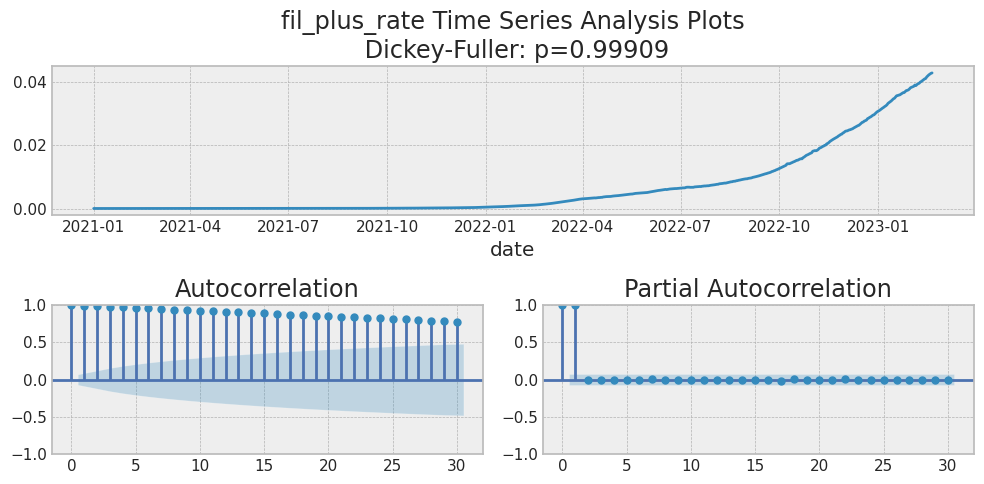

In [ ]:
#checks stationarity in Delta Fil Plus Rate
tsplot_fil_plus(data.fil_plus_rate, lags=30)

In [ ]:
#checks stationarity in Delta RBP with 1 diff
data_diff = data.fil_plus_rate - data.fil_plus_rate.shift(1)

tsplot_fil_plus(data_diff[1:], lags=30)

###Notes

<hr>
<a class="anchor" id="modeling">
    
# 6.0 Modeling and Assessment
    
</a>

In [16]:
#creates a copy from data
df_model = data.copy()

<a class="anchor" id="estimation">
    
### 6.1 Performance Estimation
    
</a>

Overview:

1. The input data is standardized using StandardScaler.
2. Five performance estimation methods are defined: holdout, inverse holdout, cross-validation, modified cross-validation, and repeated holdout. Each method takes X and y as inputs, fits the specified model to the training data, makes predictions on the test data, and calculates the MAPE and RMSE scores.
3. The five methods are tested on the input data, and the MAPE and RMSE scores for each method are stored in a results list.
4. The results list is used to create a Pandas dataframe that displays the MAPE and RMSE scores for each method.
5. The actual values and predictions for the output variable are plotted for each estimation method.

In [ ]:
#defines a new function that takes in the time series data and the model as arguments,
#and then applies the different performance estimation methods to the data using the provided model.

def test_performance_estimation_methods(X, y, model):
    # Scale the variables
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Define the performance estimation methods
    def holdout(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        # Fit the model
        fit_model = model.fit(X_train, y_train)
        # Make predictions
        y_pred = fit_model.predict(X_test)
        mape = MAPE(y_test, y_pred) * 100
        rmse = np.sqrt(MSE(y_test, y_pred))
        return mape, rmse, y_test, y_pred

    def inverse_holdout(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)
        fit_model = model.fit(X_train, y_train)
        # Make predictions
        y_pred = fit_model.predict(X_test)
        mape = MAPE(y_test, y_pred) * 100
        rmse = np.sqrt(MSE(y_test, y_pred))
        return mape, rmse, y_test, y_pred

    def cross_validation(X, y, n_splits=5):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        mape_scores = []
        rmse_scores = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit_model = model.fit(X_train, y_train)
            # Make predictions
            y_pred = fit_model.predict(X_test)
            mape_scores.append(MAPE(y_test, y_pred) * 100)
            rmse_scores.append(np.sqrt(MSE(y_test, y_pred)))
        return np.mean(mape_scores), np.mean(rmse_scores), y_test, y_pred

    def modified_cross_validation(X, y, n_splits=5):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        mape_scores = []
        rmse_scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            fit_model = model.fit(X_train, y_train)
            # Make predictions
            y_pred = fit_model.predict(X_test)
            mape_scores.append(MAPE(y_test, y_pred) * 100)
            rmse_scores.append(np.sqrt(MSE(y_test, y_pred)))
        return np.mean(mape_scores), np.mean(rmse_scores), y_test, y_pred

    def repeated_holdout(X, y, n_repeats=5):
        mape_scores = []
        rmse_scores = []
        for i in range(n_repeats):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
            fit_model = model.fit(X_train, y_train)
            y_pred = fit_model.predict(X_test)
            mape_scores.append(MAPE(y_test, y_pred) * 100)
            rmse_scores.append(np.sqrt(MSE(y_test, y_pred)))
        return np.mean(mape_scores), np.mean(rmse_scores), y_test, y_pred

    # Adjust the units of MAPE and RMSE
    def adjust_units(value):
        units = ['', 'k', 'M', 'B', 'T']
        magnitude = 0
        while abs(value) >= 1000 and magnitude < len(units) - 1:
            value /= 1000
            magnitude += 1
        return f"{value:.2f}{units[magnitude]}"

    # Test different performance estimation methods
    methods = [holdout, inverse_holdout, repeated_holdout, cross_validation, modified_cross_validation]
    results = []

    # Create subplots with 3 rows and 2 columns
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()  # Flatten the axes array to easily iterate over it

    for i, method in enumerate(methods):
        mape, rmse, y_test, y_pred = method(X, y.values)  # Modify the method calls to return y_test and y_pred
        results.append([mape, rmse])

        # Plot the actual values and predictions on the corresponding subplot
        axes[i].plot(y_test, label='Actual')
        axes[i].plot(y_pred, label='Predicted')
        axes[i].set_title(f"{method.__name__} - MAPE: {adjust_units(mape)}%, RMSE: {adjust_units(rmse)}")
        axes[i].legend()
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(y.name)

    # Remove the unused subplot
    fig.delaxes(axes[-1])

    # Add a common title to the figure
    fig.suptitle(f"Model Performance for {y.name}")

    # Adjust the layout and display the subplots
    plt.tight_layout()
    plt.show()

    # Display the results in a table
    results_df = pd.DataFrame(results, columns=['MAPE', 'RMSE'], index=['Holdout', 'Inverse Holdout', 'Repeated Holdout', 'Cross-Validation', 'Modified Cross-Validation'])
    results_df['MAPE'] = results_df['MAPE'].map(lambda x: adjust_units(x))
    results_df['RMSE'] = results_df['RMSE'].map(lambda x: adjust_units(x))
    print(results_df)


<a class="anchor" id="baseline">
    
### 6.2 Baseline Model (Linear Regression)
    
</a>

#### **Delta RBP**

In [ ]:
# Define input and output variables
y_var = 'delta_RBP'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

# Scales the input and output data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Create a linear regression model object
LR_model = LinearRegression()

# Test the performance estimation methods using the linear regression model
(X_scaled, y, LR_model)

                               MAPE    RMSE
Holdout                      134.08   19.96
Inverse Holdout               2.12k  215.42
Repeated Holdout             134.08   19.96
Cross-Validation              66.58   24.93
Modified Cross-Validation  1538.65T    3.47


#### **Fil Plus Rate**

In [ ]:
# Define input and output variables
y_var = 'fil_plus_rate'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

# Scales the input and output data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Create a linear regression model object
LR_model = LinearRegression()

# Test the performance estimation methods using the linear regression model
test_performance_estimation_methods(X_scaled, y, LR_model)

                             MAPE  RMSE
Holdout                      9.25  0.00
Inverse Holdout            11.00k  0.06
Repeated Holdout             9.25  0.00
Cross-Validation            6.23k  0.01
Modified Cross-Validation  177.85  0.00


###Notes


<a class="anchor" id="arima">
    
### 6.3 ARIMA Model (Box Jenkins)
    
</a>

#### **Delta RBP**

##### Searching best parameters with auto_arima

In [ ]:
# # Define input and output variables
# y_var = 'delta_RBP'
# X = df_model.drop(y_var, axis=1)
# y = df_model[y_var]

# # Splits the dataset in Train and Test
# train_size = int(len(df_model) * 0.8)
# train_y = y[:train_size]
# train_X = X[:train_size]
# test_y = y[train_size:]
# test_X = X[train_size:]

# # Finding the best parameters with Auto-Arima
# fit_arima = auto_arima(train_y, exogenous=train_X, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
#                     seasonal=True,
#                            m=6,
#                            D=1,
#                            start_P=1,
#                            start_Q=1,
#                            max_P=3,
#                            max_Q=3,
#                            information_criterion='aic',
#                            suppress_warnings=True,
#                            trace=True,
#                            error_action='ignore',
#                            stepwise=False)

 ARIMA(0,1,0)(0,1,0)[6]             : AIC=7090.987, Time=0.13 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,2)[6]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,3)[6]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=6916.371, Time=0.19 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(1,1,2)[6]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(1,1,3)[6]             : AIC=inf, Time=9.40 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=6883.018, Time=0.35 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(2,1,2)[6]             : AIC=inf, Time=5.37 sec
 ARIMA(0,1,0)(2,1,3)[6]             : AIC=inf, Time=10.08 sec
 ARIMA(0,1,0)(3,1,0)[6]             : AIC=6818.528, Time=0.75 sec
 ARIMA(0,1,0)(3,1,1)[6]             : AIC=inf, Time=6.79 sec
 ARIMA(0,1,0)(3,1,2)[6]             : AIC=inf, Time=6.86 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=inf, Time=0.25 sec
 AR

In [ ]:
#prints de autoarima results
# print(fit_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  624
Model:             SARIMAX(2, 1, 0)x(3, 1, 0, 6)   Log Likelihood               -3309.820
Date:                           Mon, 22 May 2023   AIC                           6631.641
Time:                                   11:59:11   BIC                           6658.190
Sample:                               01-01-2021   HQIC                          6641.963
                                    - 09-16-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5597      0.012    -48.647      0.000      -0.582      -0.537
ar.L2         -0.3315      0.012    -27.611

### Notes

- article for reference on how to analyze the SARIMAX Results https://analyzingalpha.com/interpret-arima-results

##### ARIMA model - Delta RBP

####ARIMAWrapper

The ARIMAWrapper is a custom class that adapts the SARIMAX model from the statsmodels library to be compatible with the performance estimation functions. It provides a consistent interface with fit and predict methods, accepting 2D input matrices (X) and 1D output arrays (y), allowing seamless integration with the existing functions.

Best model:  ARIMA(2,1,0)(3,1,0)[6]

In [ ]:
#define order and seasonal order using best parameters from autoarima
order = (2,1,0)
seasonal_order = (3, 1, 0, 6)

class ARIMAWrapper:
    def __init__(self, order, seasonal_order):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order).fit()
        return self

    def predict(self, X, y=None):
        return self.model.forecast(steps=len(X), exog=X)


# Define input and output variables
y_var = 'delta_RBP'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

#scales the input and output data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Splits the dataset in Train and Test
train_size = int(len(df_model) * 0.8)
train_y = y[:train_size]
train_X = X_scaled[:train_size]
test_y = y[train_size:]
test_X = X_scaled[train_size:]


# Create a ARIMA model object
arima_wrapper = ARIMAWrapper(order=order, seasonal_order=seasonal_order)

# Test the performance estimation methods using the ARIMA model
test_performance_estimation_methods(X_scaled, y, arima_wrapper)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

                                 MAPE    RMSE
Holdout                         2.70k  351.60
Inverse Holdout                17.60k   1.70k
Repeated Holdout                2.70k  351.60
Cross-Validation                1.13k  243.79
Modified Cross-Validation  421628.49T  345.09


###Notes


#### **Fil Plus Rate**

##### Searching best parameters with auto_arima

In [ ]:
# # Define input and output variables
# y_var = 'fil_plus_rate'
# X = df_model.drop(y_var, axis=1)
# y = df_model[y_var]

# # Splits the dataset in Train and Test
# train_size = int(len(df_model) * 0.8)
# train_y = y[:train_size]
# train_X = X[:train_size]
# test_y = y[train_size:]
# test_X = X[train_size:]

# # Finding the best parameters with Auto-Arima
# fit_arima = auto_arima(train_y, exogenous=train_X, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
#                     seasonal=True,
#                            m=6,
#                            D=1,
#                            start_P=1,
#                            start_Q=1,
#                            max_P=3,
#                            max_Q=3,
#                            information_criterion='aic',
#                            suppress_warnings=True,
#                            trace=True,
#                            error_action='ignore',
#                            stepwise=False)

 ARIMA(0,1,0)(0,1,0)[6]             : AIC=-11378.483, Time=0.25 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=-11479.064, Time=0.39 sec
 ARIMA(0,1,0)(0,1,2)[6]             : AIC=-11483.971, Time=0.68 sec
 ARIMA(0,1,0)(0,1,3)[6]             : AIC=-11602.785, Time=1.06 sec
 ARIMA(0,1,0)(1,1,0)[6]             : AIC=-11520.142, Time=0.66 sec
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=-11477.154, Time=0.42 sec
 ARIMA(0,1,0)(1,1,2)[6]             : AIC=-11485.723, Time=1.27 sec
 ARIMA(0,1,0)(1,1,3)[6]             : AIC=-11488.073, Time=3.19 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=-11488.412, Time=0.81 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=-11487.701, Time=0.68 sec
 ARIMA(0,1,0)(2,1,2)[6]             : AIC=-11489.087, Time=0.74 sec
 ARIMA(0,1,0)(2,1,3)[6]             : AIC=-11574.128, Time=0.86 sec
 ARIMA(0,1,0)(3,1,0)[6]             : AIC=-11485.254, Time=0.52 sec
 ARIMA(0,1,0)(3,1,1)[6]             : AIC=-11578.903, Time=0.60 sec
 ARIMA(0,1,0)(3,1,2)[6]             : AIC=-11487

In [ ]:
#prints de autoarima results
# print(fit_arima.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  624
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2, 3], 6)   Log Likelihood                5805.392
Date:                                   Mon, 22 May 2023   AIC                         -11602.785
Time:                                           12:19:07   BIC                         -11585.085
Sample:                                       01-01-2021   HQIC                        -11595.903
                                            - 09-16-2022                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L6       -0.6440   2.06e-19  -3.12e+18      0.000    

##### ARIMA model - Fil Plus Rate

Best model:  ARIMA(0,1,0)(0,1,3)[6]

In [ ]:
#define order and seasonal order using best parameters from autoarima
order = (0,1,0)
seasonal_order = (0, 1, 3, 6)

class ARIMAWrapper:
    def __init__(self, order, seasonal_order):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order).fit()
        return self

    def predict(self, X, y=None):
        return self.model.forecast(steps=len(X), exog=X)


# Define input and output variables
y_var = 'fil_plus_rate'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

#scales the input and output data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Splits the dataset in Train and Test
train_size = int(len(df_model) * 0.8)
train_y = y[:train_size]
train_X = X_scaled[:train_size]
test_y = y[train_size:]
test_X = X_scaled[train_size:]

# Create a ARIMA model object
arima_wrapper = ARIMAWrapper(order=order, seasonal_order=seasonal_order)

# Test the performance estimation methods using the ARIMA model
test_performance_estimation_methods(X_scaled, y, arima_wrapper)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

                             MAPE  RMSE
Holdout                      7.15  0.00
Inverse Holdout             6.76k  0.03
Repeated Holdout             7.15  0.00
Cross-Validation            3.93k  0.00
Modified Cross-Validation  12.87k  0.01


###Notes

<a class="anchor" id="lstm">
    
### 6.4 Long Short Term Memory (LSTM)
    
</a>

### Introduction

#### **Delta RBP**

In [ ]:
# Define input and output variables
y_var = 'delta_RBP'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

In [ ]:
#creates a function to build the LSTM model
def create_lstm_model(neurons=50, activation='relu', optimizer='adam', dropout=0.2):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
#creates a wrapper for the LSTM model suits the function test_performance_estimation_methods
class LSTMWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        self.model.fit(X, y, epochs=50, batch_size=1, verbose=0)
        return self

    def predict(self, X, y=None):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        return self.model.predict(X).flatten()

In [ ]:
#scales the input and output data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [ ]:
#splits the data into train and test
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = next(tscv.split(X_scaled))
X_train, X_test = X_scaled[train_index], X_scaled[test_index]
y_train, y_test = y[train_index], y[test_index]

In [ ]:
# #uses GridSearch to find the best parameters for the model
# lstm_regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# param_grid = {
#     'neurons': [50, 100],
#     'activation': ['relu', 'tanh'],
#     'optimizer': ['adam', 'rmsprop'],
#     'dropout': [0.2, 0.5]
# }

# grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=tscv, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)
# best_params = grid_result.best_params_

In [ ]:
#best_params

{'activation': 'tanh', 'dropout': 0.5, 'neurons': 100, 'optimizer': 'rmsprop'}

In [ ]:
best_params = {'activation': 'tanh', 'dropout': 0.5, 'neurons': 100, 'optimizer': 'rmsprop'}

In [ ]:
#creates the LSTM model using the best parameters
best_lstm_model = create_lstm_model(**best_params)

In [ ]:
#uses the function LSTMWraper to convert the
lstm_wrapper = LSTMWrapper(best_lstm_model)

5/5 [==============================] - 0s 8ms/step


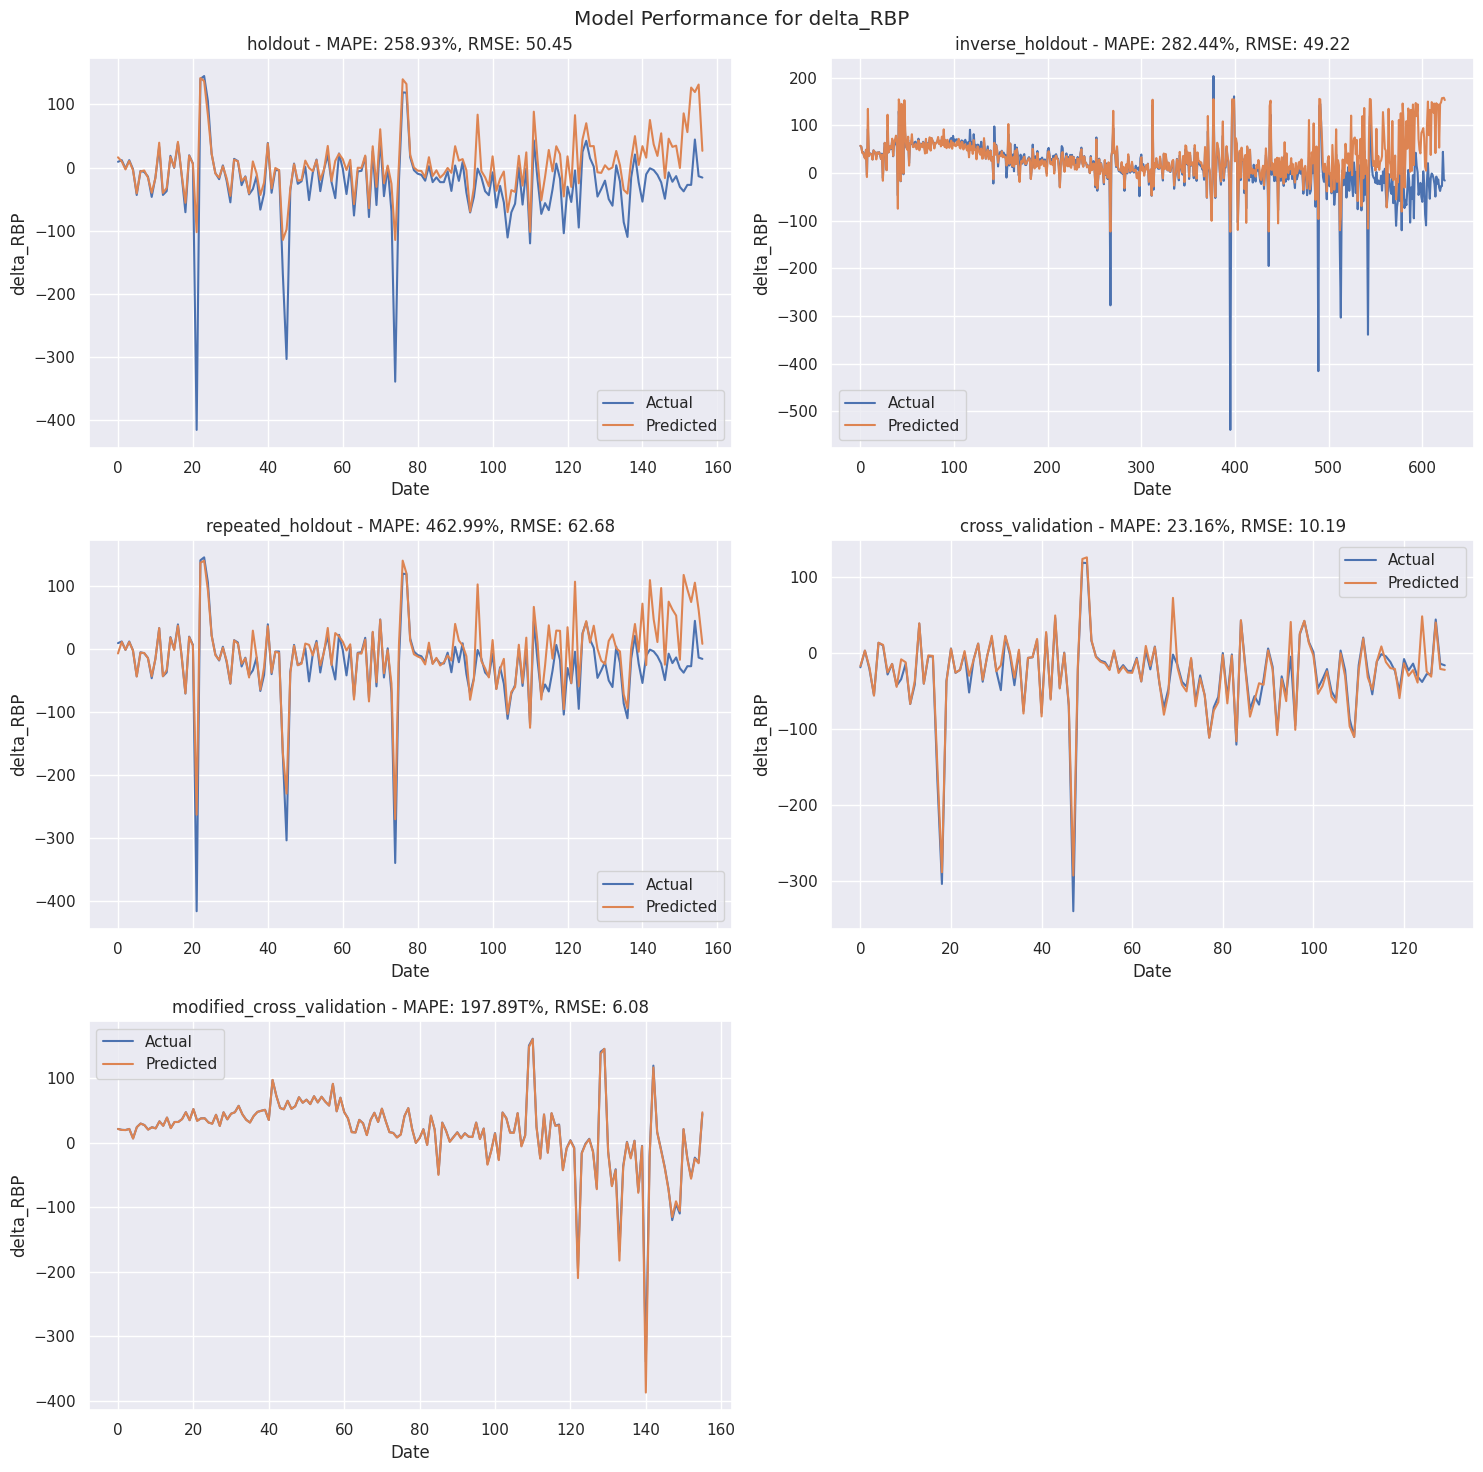

                              MAPE   RMSE
Holdout                     258.93  50.45
Inverse Holdout             282.44  49.22
Repeated Holdout            462.99  62.68
Cross-Validation             23.16  10.19
Modified Cross-Validation  197.89T   6.08


In [ ]:
#tests its performance with the test_performance_estimation_methods function
X_scaled_df = pd.DataFrame(X_scaled)

test_performance_estimation_methods(X_scaled_df, y, lstm_wrapper)

#### **Fil Plus Rate**

In [ ]:
# Define input and output variables
y_var = 'fil_plus_rate'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

In [ ]:
#creates a function to build the LSTM model
def create_lstm_model(neurons=50, activation='relu', optimizer='adam', dropout=0.2):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [ ]:
#creates a wrapper for the LSTM model suits the function test_performance_estimation_methods
class LSTMWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        self.model.fit(X, y, epochs=50, batch_size=1, verbose=0)
        return self

    def predict(self, X, y=None):
        X = X.reshape(X.shape[0], X.shape[1], 1)
        return self.model.predict(X).flatten()

In [ ]:
#scales the input and output data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [ ]:
#splits the data into train and test
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = next(tscv.split(X_scaled))
X_train, X_test = X_scaled[train_index], X_scaled[test_index]
y_train, y_test = y[train_index], y[test_index]

In [ ]:
# #uses GridSearch to find the best parameters for the model
# lstm_regressor = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# param_grid = {
#     'neurons': [50, 100],
#     'activation': ['relu', 'tanh'],
#     'optimizer': ['adam', 'rmsprop'],
#     'dropout': [0.2, 0.5]
# }

# grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, cv=tscv, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)
# best_params = grid_result.best_params_

best paramenters found: {'activation': 'tanh', 'dropout': 0.5, 'neurons': 100, 'optimizer': 'rmsprop'}

In [ ]:
best_params = {'activation': 'tanh', 'dropout': 0.5, 'neurons': 100, 'optimizer': 'rmsprop'}

In [ ]:
#creates the LSTM model using the best parameters
best_lstm_model = create_lstm_model(**best_params)

In [ ]:
#uses the function LSTMWraper to convert the
lstm_wrapper = LSTMWrapper(best_lstm_model)

5/5 [==============================] - 0s 5ms/step


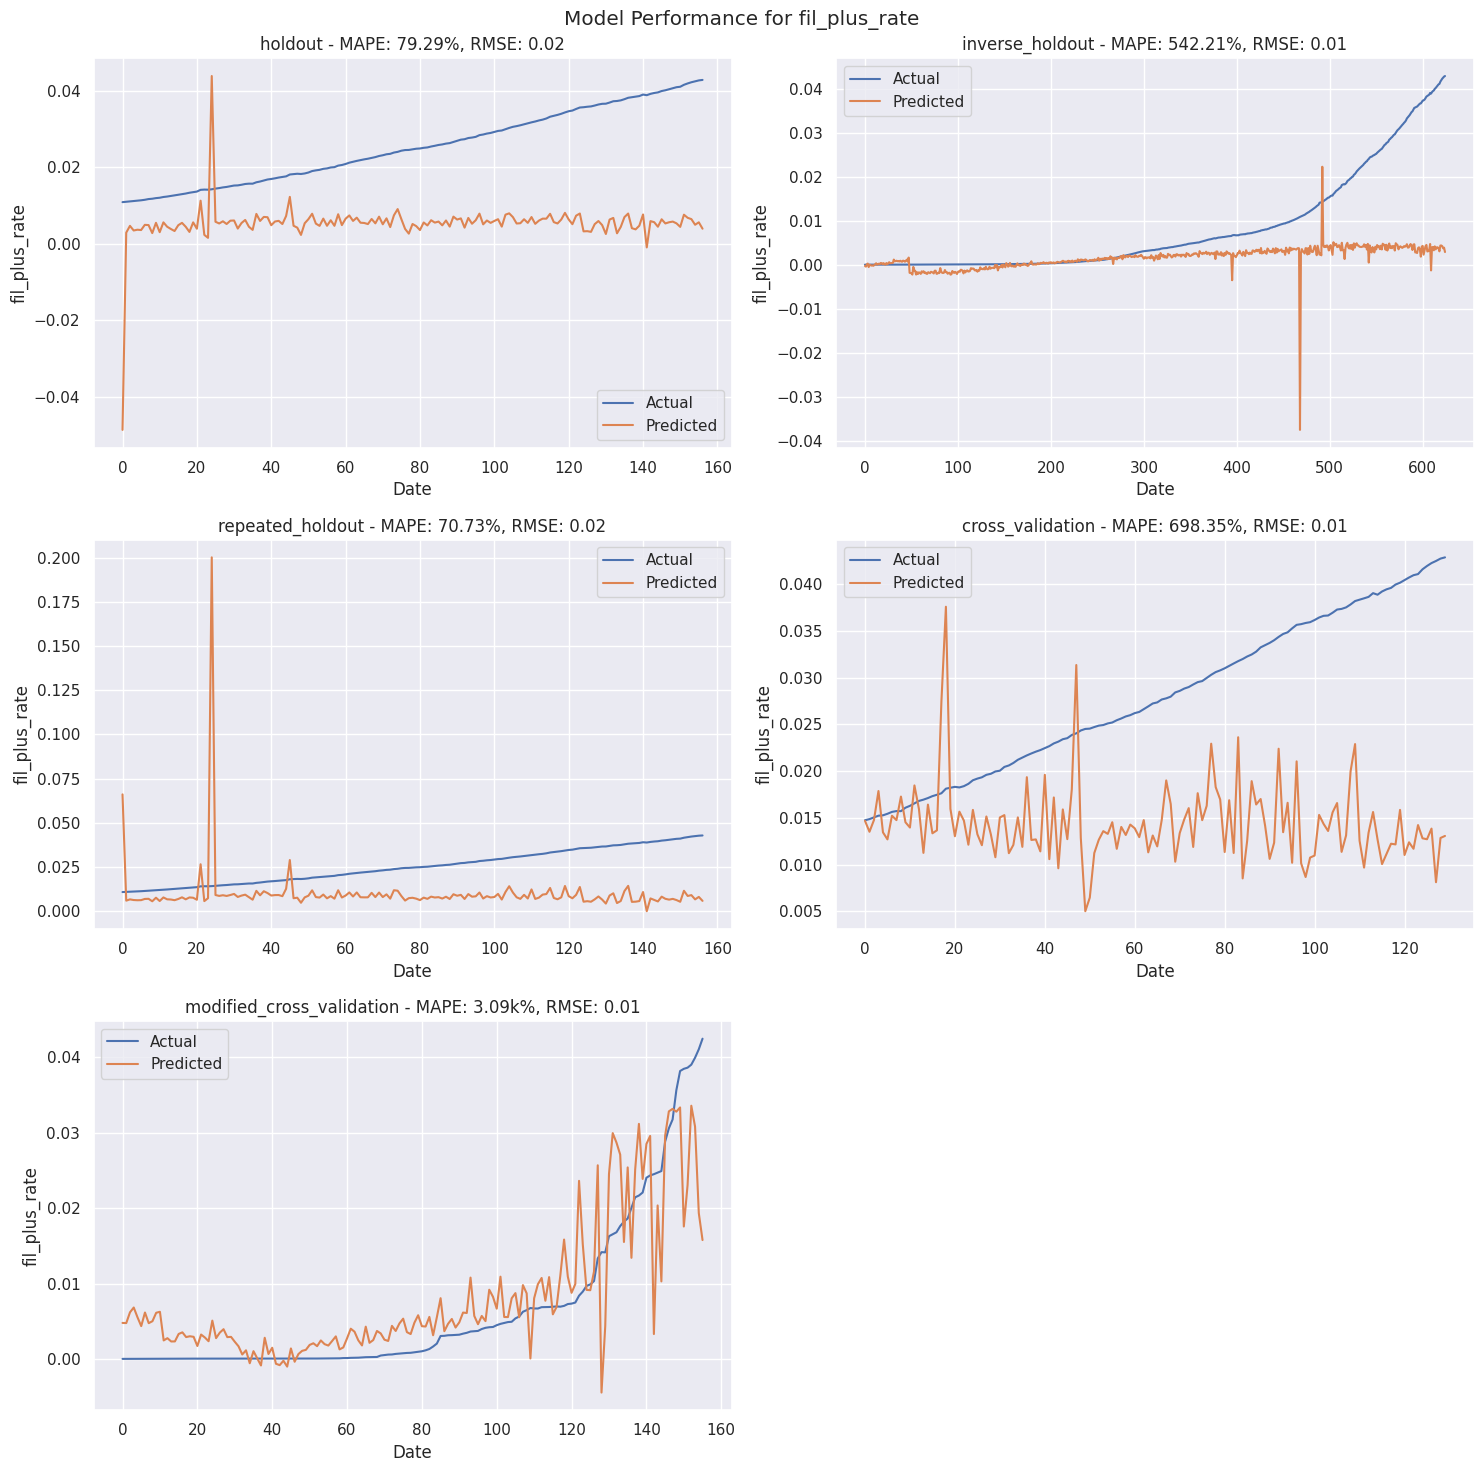

                             MAPE  RMSE
Holdout                     79.29  0.02
Inverse Holdout            542.21  0.01
Repeated Holdout            70.73  0.02
Cross-Validation           698.35  0.01
Modified Cross-Validation   3.09k  0.01


In [ ]:
#tests its performance with the test_performance_estimation_methods function
X_scaled_df = pd.DataFrame(X_scaled)

test_performance_estimation_methods(X_scaled, y, lstm_wrapper)

###Notes

<a class="anchor" id="ensemble">
    
### 6.5 Ensemble Learning (LSTM + CNN)
    
</a>

####**Introduction**:


#### **Delta RBP**

In [ ]:
# Define input and output variables
y_var = 'delta_RBP'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

In [ ]:
# Scale the variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

#splits the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Reshape the input data for LSTM and CNN models
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# # Convert DataFrames to NumPy arrays
# X_train_np = X_train.to_numpy()
# X_test_np = X_test.to_numpy()
# y_train_np = y_train.to_numpy()
# y_test_np = y_test.to_numpy()

# # Reshapes the data for LSTM and CNN models
# X_train_reshaped = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
# X_test_reshaped = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

In [ ]:
# Train the LSTM model
lstm_model = Sequential()
#best_parameters from GridSearch: {'activation': 'tanh', 'dropout': 0.5, 'neurons': 100, 'optimizer': 'rmsprop'}
lstm_model.add(LSTM(100, activation='tanh', dropout= 0.5, input_shape=(X_train_reshaped.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='rmsprop', loss='mse')
# Train the LSTM model
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=1, verbose=0)

In [ ]:
# Function to create the CNN model
def create_cnn_model(filters=64, kernel_size=2, pool_size=2, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(50, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
# Wrap the model using KerasClassifier
cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=50, batch_size=32, verbose=0)

# Define the parameter grid for the grid search
param_grid = {
    'filters': [32, 64, 128],
    'kernel_size': [2, 3, 4],
    'pool_size': [2, 3],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'rmsprop']
}

# Perform the grid search using GridSearchCV
grid_search = GridSearchCV(estimator=cnn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid_search.fit(X_train_reshaped, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found:", grid_result.best_params_)
print("Best score (negative mean squared error):", grid_result.best_score_)

7/7 [==============================] - 0s 3ms/step
Best parameters found: {'activation': 'relu', 'filters': 128, 'kernel_size': 2, 'optimizer': 'rmsprop', 'pool_size': 2}
Best score (negative mean squared error): -68929.70413657051


CNN Best parameters found: {'activation': 'tanh', 'filters': 128, 'kernel_size': 4, 'optimizer': 'adam', 'pool_size': 2}

In [ ]:
# grid_result.best_params_

{'activation': 'relu',
 'filters': 128,
 'kernel_size': 2,
 'optimizer': 'rmsprop',
 'pool_size': 2}

In [ ]:
# defines the best parameters from GridSearchCV
best_params = {'activation': 'tanh', 'filters': 128, 'kernel_size': 2, 'optimizer': 'rmsprop', 'pool_size': 2}

In [ ]:
# Train the CNN model with the best parameters
cnn_model = create_cnn_model(filters=best_params['filters'], kernel_size=best_params['kernel_size'], pool_size=best_params['pool_size'], activation=best_params['activation'], optimizer=best_params['optimizer'])
# Train the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)

In [ ]:
#makes the predictions with the base models on the testing and testing data
lstm_pred_train = lstm_model.predict(X_train_reshaped)
lstm_pred_test = lstm_model.predict(X_test_reshaped)

cnn_pred_train = cnn_model.predict(X_train_reshaped)
cnn_pred_test = cnn_model.predict(X_test_reshaped)

5/5 [==============================] - 0s 4ms/step


In [ ]:
# checks if the base model predictions contain NaN values
print("lstm_pred_train contain NaN:", np.isnan(lstm_pred_train).any())
print("lstm_pred_test contain NaN:", np.isnan(lstm_pred_test).any())
print("cnn_pred_train contain NaN:", np.isnan(cnn_pred_train).any())
print("cnn_pred_test contain NaN:", np.isnan(cnn_pred_test).any())

lstm_pred_train contain NaN: False
lstm_pred_test contain NaN: False
cnn_pred_train contain NaN: False
cnn_pred_test contain NaN: False


In [ ]:
# checks the shape of the predictions from both base models
print("lstm_pred_train shape:", lstm_pred_train.shape)
print("lstm_pred_test shape:", lstm_pred_test.shape)
print("cnn_pred_train shape:", cnn_pred_train.shape)
print("cnn_pred_test shape:", cnn_pred_test.shape)

lstm_pred_train shape: (624, 1)
lstm_pred_test shape: (157, 1)
cnn_pred_train shape: (624, 1)
cnn_pred_test shape: (157, 1)


In [ ]:
#creates the ensemble model
ensemble_pred_train = 0.5 * lstm_pred_train + 0.5 * cnn_pred_train
ensemble_pred_test = 0.5 * lstm_pred_test + 0.5 * cnn_pred_test

In [ ]:
# creates the EnsembleModelWrapper class
class EnsembleModelWrapper:
    def __init__(self, lstm_model, cnn_model, weights=(0.5, 0.5)):
        self.lstm_model = lstm_model
        self.cnn_model = cnn_model
        self.weights = weights

    def fit(self, X_train, y_train):
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        self.lstm_model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)
        self.cnn_model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)
        return self

    def predict(self, X):
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        lstm_pred = self.lstm_model.predict(X_reshaped)
        cnn_pred = self.cnn_model.predict(X_reshaped)
        ensemble_pred = self.weights[0] * lstm_pred + self.weights[1] * cnn_pred
        return ensemble_pred

#creates a new instance of the EnsembleModelWrapper class with the LSTM and CNN models
ensemble_model_wrapper = EnsembleModelWrapper(lstm_model, cnn_model)

In [ ]:
#uses the test_performance_estimation_methods function to assess the ensemble model
test_performance_estimation_methods(X, y, ensemble_model_wrapper)

5/5 [==============================] - 0s 3ms/step


                               MAPE   RMSE
Holdout                      334.14  58.17
Inverse Holdout              165.80  38.63
Repeated Holdout             460.07  59.08
Cross-Validation             187.31  27.23
Modified Cross-Validation  2266.12T  15.43


#### **Fil Plus Rate**

In [ ]:
# Define input and output variables
y_var = 'fil_plus_rate'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

In [ ]:
# Scale the variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

#splits the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Reshape the input data for LSTM and CNN models
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Train the LSTM model
lstm_model = Sequential()
#best_parameters from GridSearch: {'activation': 'tanh', 'dropout': 0.5, 'neurons': 100, 'optimizer': 'rmsprop'}
lstm_model.add(LSTM(100, activation='tanh', dropout= 0.5, input_shape=(X_train_reshaped.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='rmsprop', loss='mse')
# Train the LSTM model
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=1, verbose=0)

In [ ]:
# Function to create the CNN model
def create_cnn_model(filters=64, kernel_size=2, pool_size=2, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(50, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
# # Wrap the model using KerasClassifier
# cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=50, batch_size=32, verbose=0)

# # Define the parameter grid for the grid search
# param_grid = {
#     'filters': [32, 64, 128],
#     'kernel_size': [2, 3, 4],
#     'pool_size': [2, 3],
#     'activation': ['relu', 'tanh'],
#     'optimizer': ['adam', 'rmsprop']
# }

# # Perform the grid search using GridSearchCV
# grid_search = GridSearchCV(estimator=cnn_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
# grid_result = grid_search.fit(X_train_reshaped, y_train)

# # Print the best parameters and the corresponding score
# print("Best parameters found:", grid_result.best_params_)
# print("Best score (negative mean squared error):", grid_result.best_score_)

7/7 [==============================] - 0s 3ms/step
Best parameters found: {'activation': 'relu', 'filters': 64, 'kernel_size': 2, 'optimizer': 'adam', 'pool_size': 3}
Best score (negative mean squared error): -1.208088539666587e-05


In [ ]:
# grid_result.best_params_

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 2,
 'optimizer': 'adam',
 'pool_size': 3}

In [ ]:
# defines the best parameters from GridSearchCV
best_params = {'activation': 'relu', 'filters': 64, 'kernel_size': 2, 'optimizer': 'adam', 'pool_size': 3}

In [ ]:
# Train the CNN model with the best parameters
cnn_model = create_cnn_model(filters=best_params['filters'], kernel_size=best_params['kernel_size'], pool_size=best_params['pool_size'], activation=best_params['activation'], optimizer=best_params['optimizer'])
# Train the CNN model
cnn_model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)

In [ ]:
#makes the predictions with the base models on the testing and testing data
lstm_pred_train = lstm_model.predict(X_train_reshaped)
lstm_pred_test = lstm_model.predict(X_test_reshaped)

cnn_pred_train = cnn_model.predict(X_train_reshaped)
cnn_pred_test = cnn_model.predict(X_test_reshaped)

5/5 [==============================] - 0s 3ms/step


In [ ]:
# checks if the base model predictions contain NaN values
print("lstm_pred_train contain NaN:", np.isnan(lstm_pred_train).any())
print("lstm_pred_test contain NaN:", np.isnan(lstm_pred_test).any())
print("cnn_pred_train contain NaN:", np.isnan(cnn_pred_train).any())
print("cnn_pred_test contain NaN:", np.isnan(cnn_pred_test).any())

lstm_pred_train contain NaN: False
lstm_pred_test contain NaN: False
cnn_pred_train contain NaN: False
cnn_pred_test contain NaN: False


In [ ]:
# checks the shape of the predictions from both base models
print("lstm_pred_train shape:", lstm_pred_train.shape)
print("lstm_pred_test shape:", lstm_pred_test.shape)
print("cnn_pred_train shape:", cnn_pred_train.shape)
print("cnn_pred_test shape:", cnn_pred_test.shape)

lstm_pred_train shape: (624, 1)
lstm_pred_test shape: (157, 1)
cnn_pred_train shape: (624, 1)
cnn_pred_test shape: (157, 1)


In [ ]:
#creates the ensemble model
ensemble_pred_train = 0.5 * lstm_pred_train + 0.5 * cnn_pred_train
ensemble_pred_test = 0.5 * lstm_pred_test + 0.5 * cnn_pred_test

In [ ]:
# creates the EnsembleModelWrapper class
class EnsembleModelWrapper:
    def __init__(self, lstm_model, cnn_model, weights=(0.5, 0.5)):
        self.lstm_model = lstm_model
        self.cnn_model = cnn_model
        self.weights = weights

    def fit(self, X_train, y_train):
        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        self.lstm_model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)
        self.cnn_model.fit(X_train_reshaped, y_train, epochs=100, verbose=0)
        return self

    def predict(self, X):
        X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
        lstm_pred = self.lstm_model.predict(X_reshaped)
        cnn_pred = self.cnn_model.predict(X_reshaped)
        ensemble_pred = self.weights[0] * lstm_pred + self.weights[1] * cnn_pred
        return ensemble_pred

#creates a new instance of the EnsembleModelWrapper class with the LSTM and CNN models
ensemble_model_wrapper = EnsembleModelWrapper(lstm_model, cnn_model)

5/5 [==============================] - 0s 3ms/step


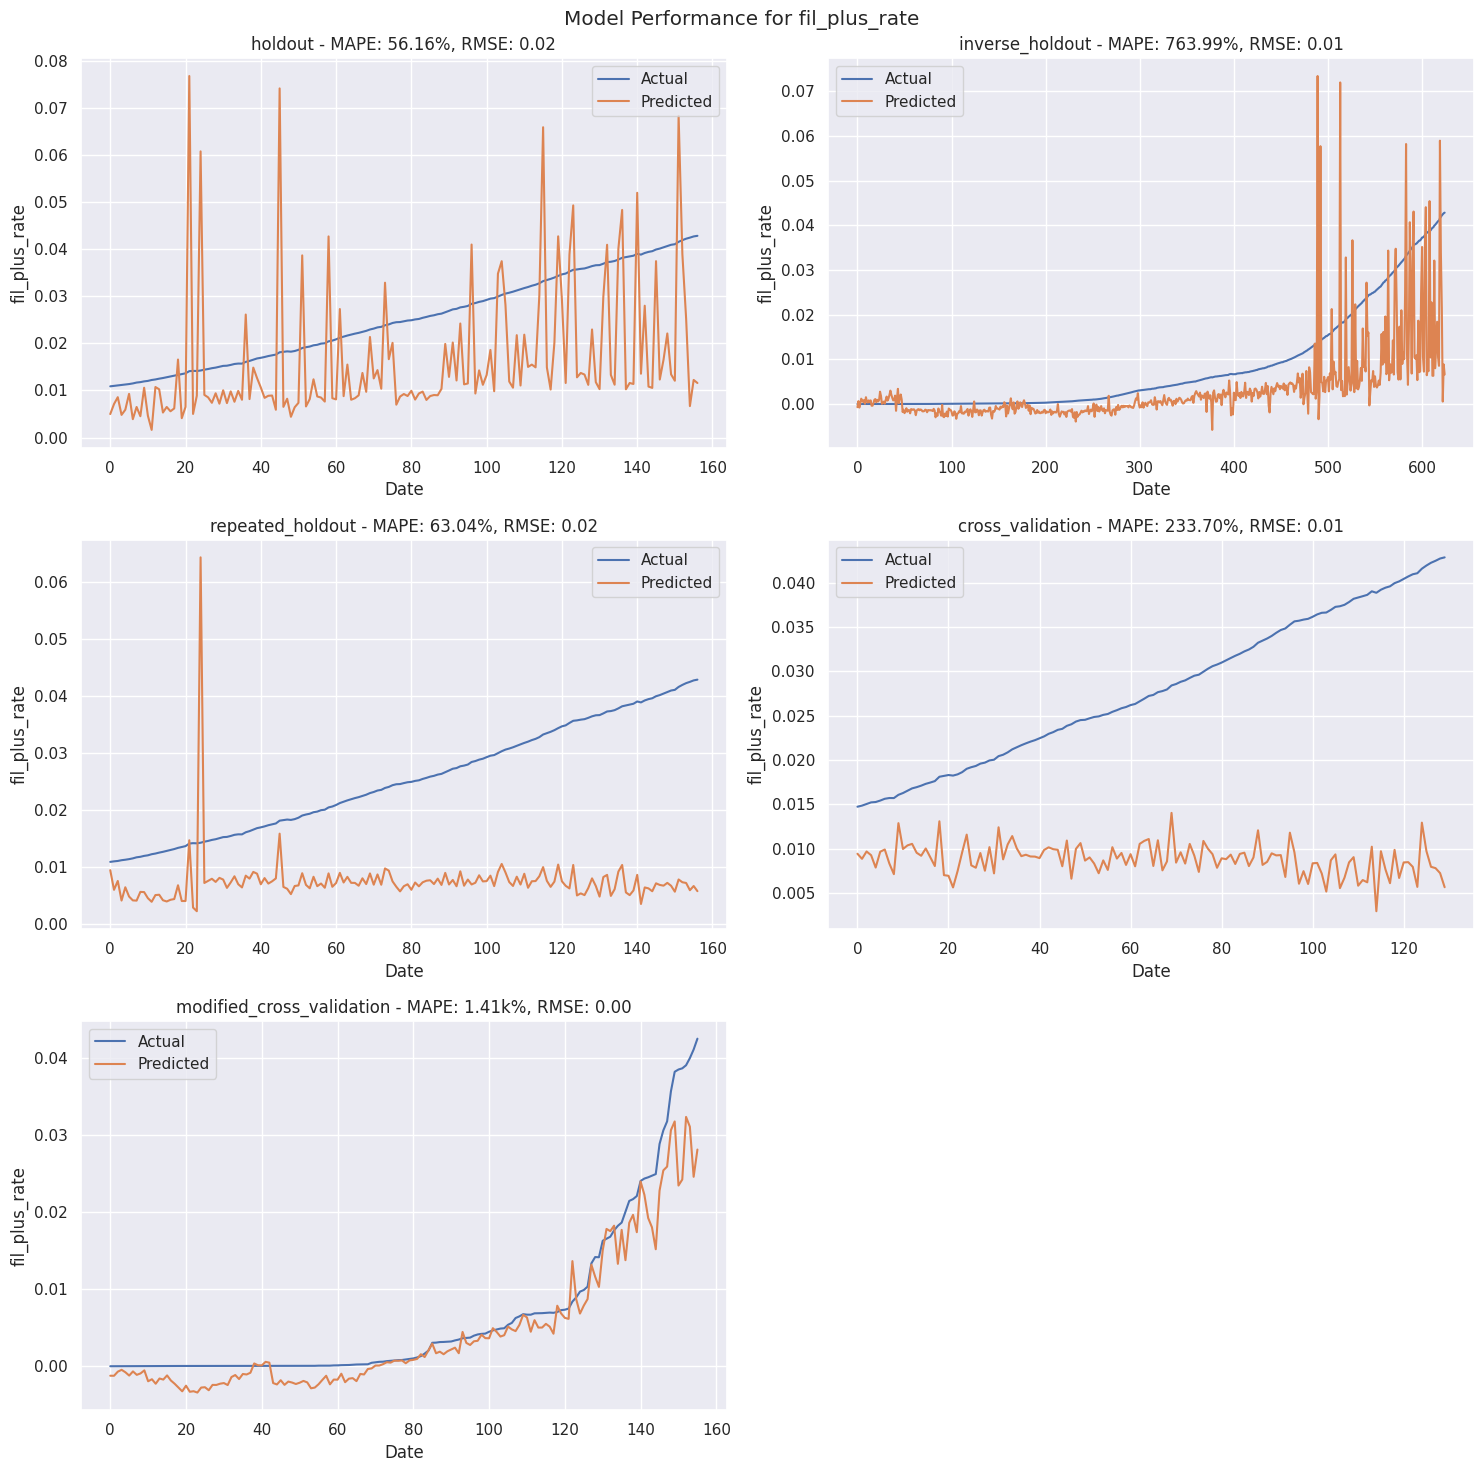

                             MAPE  RMSE
Holdout                     56.16  0.02
Inverse Holdout            763.99  0.01
Repeated Holdout            63.04  0.02
Cross-Validation           233.70  0.01
Modified Cross-Validation   1.41k  0.00


In [ ]:
#uses the test_performance_estimation_methods function to assess the ensemble model
test_performance_estimation_methods(X, y, ensemble_model_wrapper)

###Notes


<a class="anchor" id="smoothing">
    
### 6.6 Exponential Smoothing
    
</a>

####**Introduction**:
 Exponential Smoothing is a technique used for time series forecasting. It can be used to remove noise and make predictions based on historical data. There are different variations of Exponential Smoothing, such as Simple Exponential Smoothing, Double Exponential Smoothing (Holt's method), and Triple Exponential Smoothing (Holt-Winters method).

For this model, the data is splited into training and testing sets, then a fit of the Simple Exponential Smoothing model is made on the training data, as well as the predictions for the test data. The smoothing_level parameter (alpha) controls the degree of smoothing, with values closer to 1 resulting in less smoothing and values closer to 0 resulting in more smoothing.

It is important to keep in mind that Exponential Smoothing methods are univariate, meaning they only consider the historical values of the variable that we are trying to predict (y in this case) and do not take into account any input variables (X).




#### **Delta RBP**

In [ ]:
# defines input and output variables
y_var = 'delta_RBP'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

In [ ]:
# Scale the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# defines a function to calculate the mean squared error for a given smoothing level
def evaluate_smoothing_level(alpha, y):
    model = SimpleExpSmoothing(y)
    model_fit = model.fit(smoothing_level=alpha, optimized=False)
    smoothed_y = model_fit.fittedvalues
    mse = MSE(y, smoothed_y)
    return mse

In [ ]:
# defines a function and uses cross-validation to find the best smoothing level
def find_best_smoothing_level(y, alphas, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_alpha = None
    best_mse = float('inf')

    for alpha in alphas:
        mse_sum = 0
        for train_index, test_index in tscv.split(y):
            y_train, y_test = y[train_index], y[test_index]
            mse = evaluate_smoothing_level(alpha, y_train)
            mse_sum += mse

        mse_avg = mse_sum / n_splits
        if mse_avg < best_mse:
            best_mse = mse_avg
            best_alpha = alpha

    return best_alpha

In [ ]:
#calls the find_best_smoothing_level function with a range of possible smoothing levels
alphas = np.linspace(0.01, 1, 100)
best_alpha = find_best_smoothing_level(y, alphas)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

In [ ]:
# best_alpha

0.06999999999999999

In [ ]:
best_alpha_delta_RBP = 0.06999999999999999

In [ ]:
# defines the Exponential Smoothing model wrapper
class ExponentialSmoothingWrapper:
    def __init__(self, smoothing_level= best_alpha_delta_RBP):
        self.smoothing_level = smoothing_level

    def fit(self, X_train, y_train):
        self.model = SimpleExpSmoothing(y_train)
        self.model_fit = self.model.fit(smoothing_level=self.smoothing_level, optimized=False)
        return self

    def predict(self, X):
        return self.model_fit.forecast(len(X))


In [ ]:
# creates an instance of the Exponential Smoothing model wrapper
exp_smoothing_model = ExponentialSmoothingWrapper(smoothing_level= best_alpha_delta_RBP)

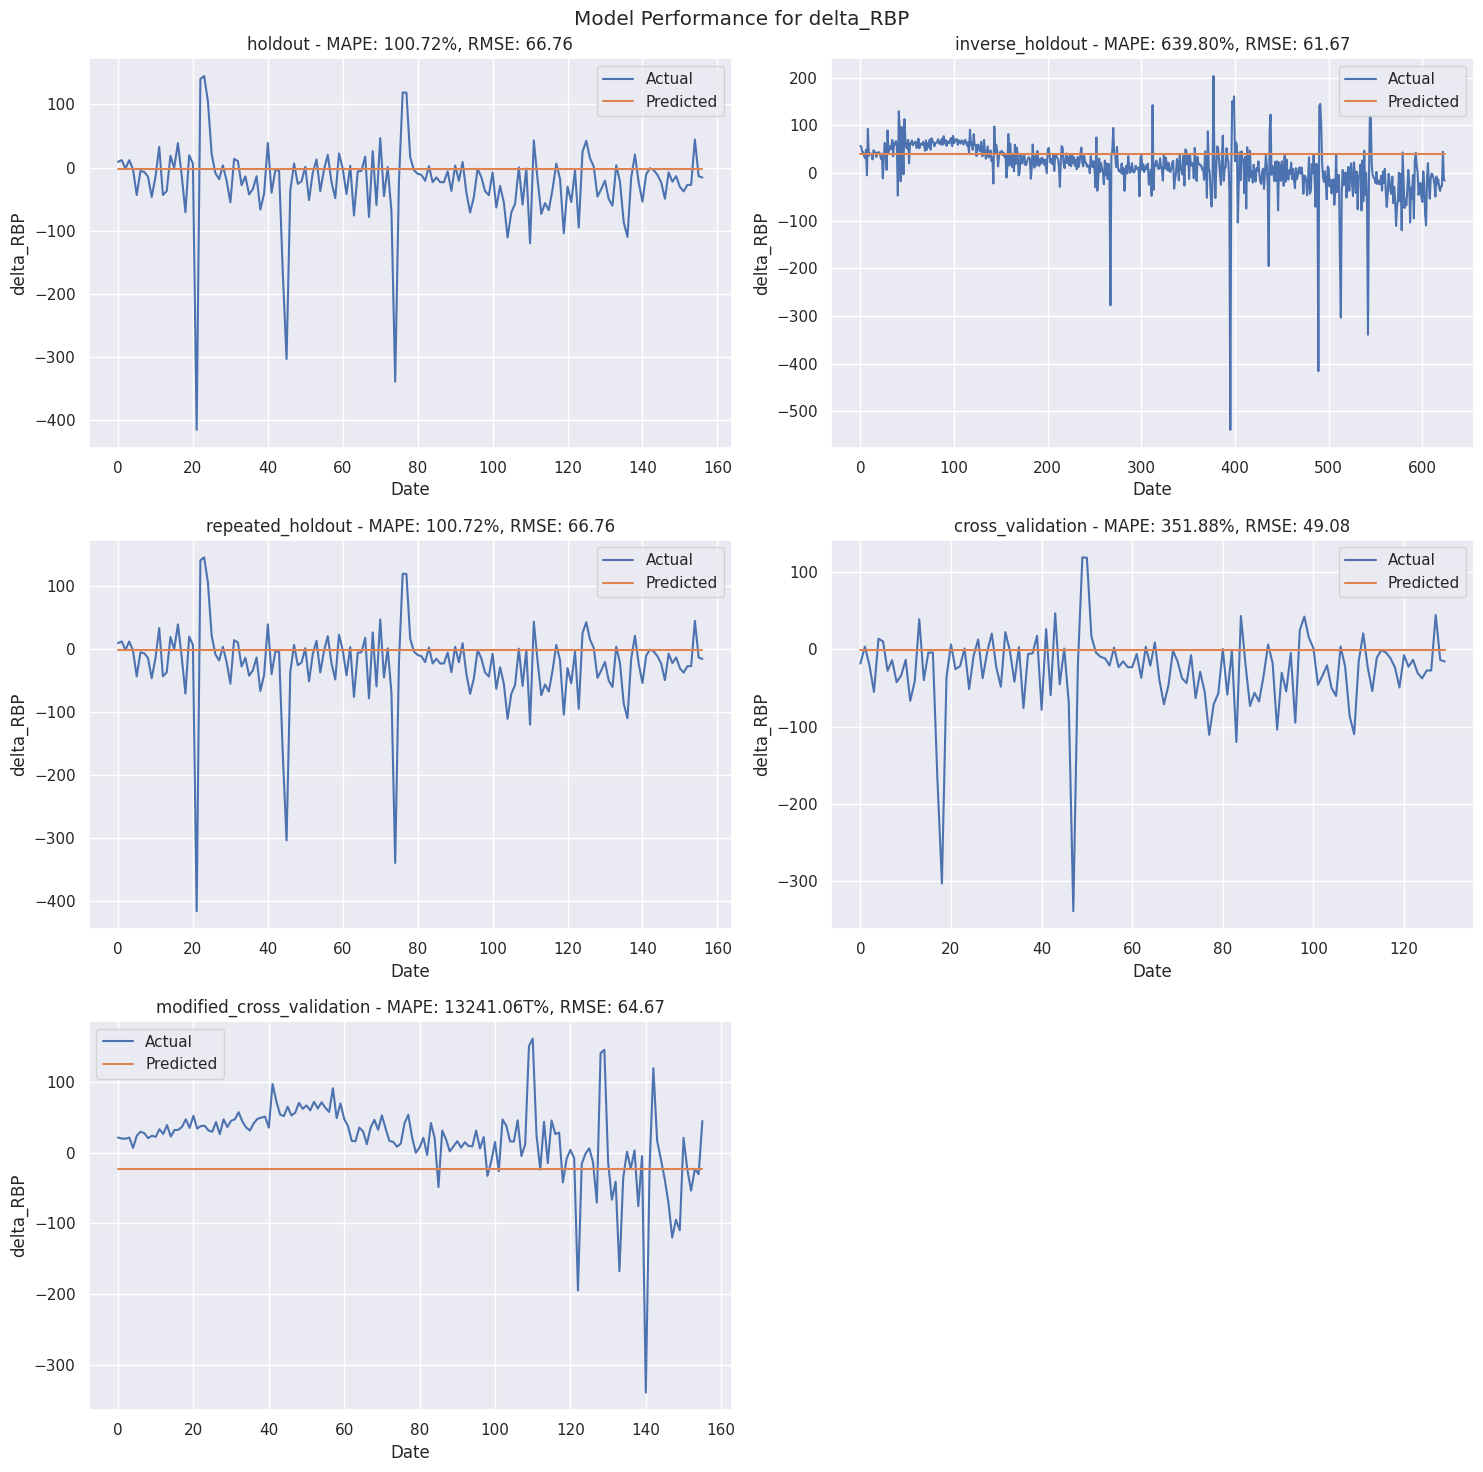

                                MAPE   RMSE
Holdout                       100.72  66.76
Inverse Holdout               639.80  61.67
Repeated Holdout              100.72  66.76
Cross-Validation              351.88  49.08
Modified Cross-Validation  13241.06T  64.67


In [ ]:
# tests the performance of the Exponential Smoothing model using your function
test_performance_estimation_methods(X_scaled, y, exp_smoothing_model)

#### **Fil Plus Rate**

In [ ]:
# defines input and output variables
y_var = 'fil_plus_rate'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

In [ ]:
# Scale the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# defines a function to calculate the mean squared error for a given smoothing level
def evaluate_smoothing_level(alpha, y):
    model = SimpleExpSmoothing(y)
    model_fit = model.fit(smoothing_level=alpha, optimized=False)
    smoothed_y = model_fit.fittedvalues
    mse = MSE(y, smoothed_y)
    return mse

In [ ]:
# defines a function and uses cross-validation to find the best smoothing level
def find_best_smoothing_level(y, alphas, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_alpha = None
    best_mse = float('inf')

    for alpha in alphas:
        mse_sum = 0
        for train_index, test_index in tscv.split(y):
            y_train, y_test = y[train_index], y[test_index]
            mse = evaluate_smoothing_level(alpha, y_train)
            mse_sum += mse

        mse_avg = mse_sum / n_splits
        if mse_avg < best_mse:
            best_mse = mse_avg
            best_alpha = alpha

    return best_alpha

In [ ]:
#supress warnings
warnings.filterwarnings("ignore")

#calls the find_best_smoothing_level function with a range of possible smoothing levels
alphas = np.linspace(0.01, 1, 100)
best_alpha = find_best_smoothing_level(y, alphas)

In [ ]:
# best_alpha

1.0

In [ ]:
best_alpha_fil_plus_rate = 1.0

In [ ]:
# defines the Exponential Smoothing model wrapper
class ExponentialSmoothingWrapper:
    def __init__(self, smoothing_level= best_alpha_fil_plus_rate):
        self.smoothing_level = smoothing_level

    def fit(self, X_train, y_train):
        self.model = SimpleExpSmoothing(y_train)
        self.model_fit = self.model.fit(smoothing_level=self.smoothing_level, optimized=False)
        return self

    def predict(self, X):
        return self.model_fit.forecast(len(X))

In [ ]:
# creates an instance of the Exponential Smoothing model wrapper
exp_smoothing_model = ExponentialSmoothingWrapper(smoothing_level= best_alpha_fil_plus_rate)

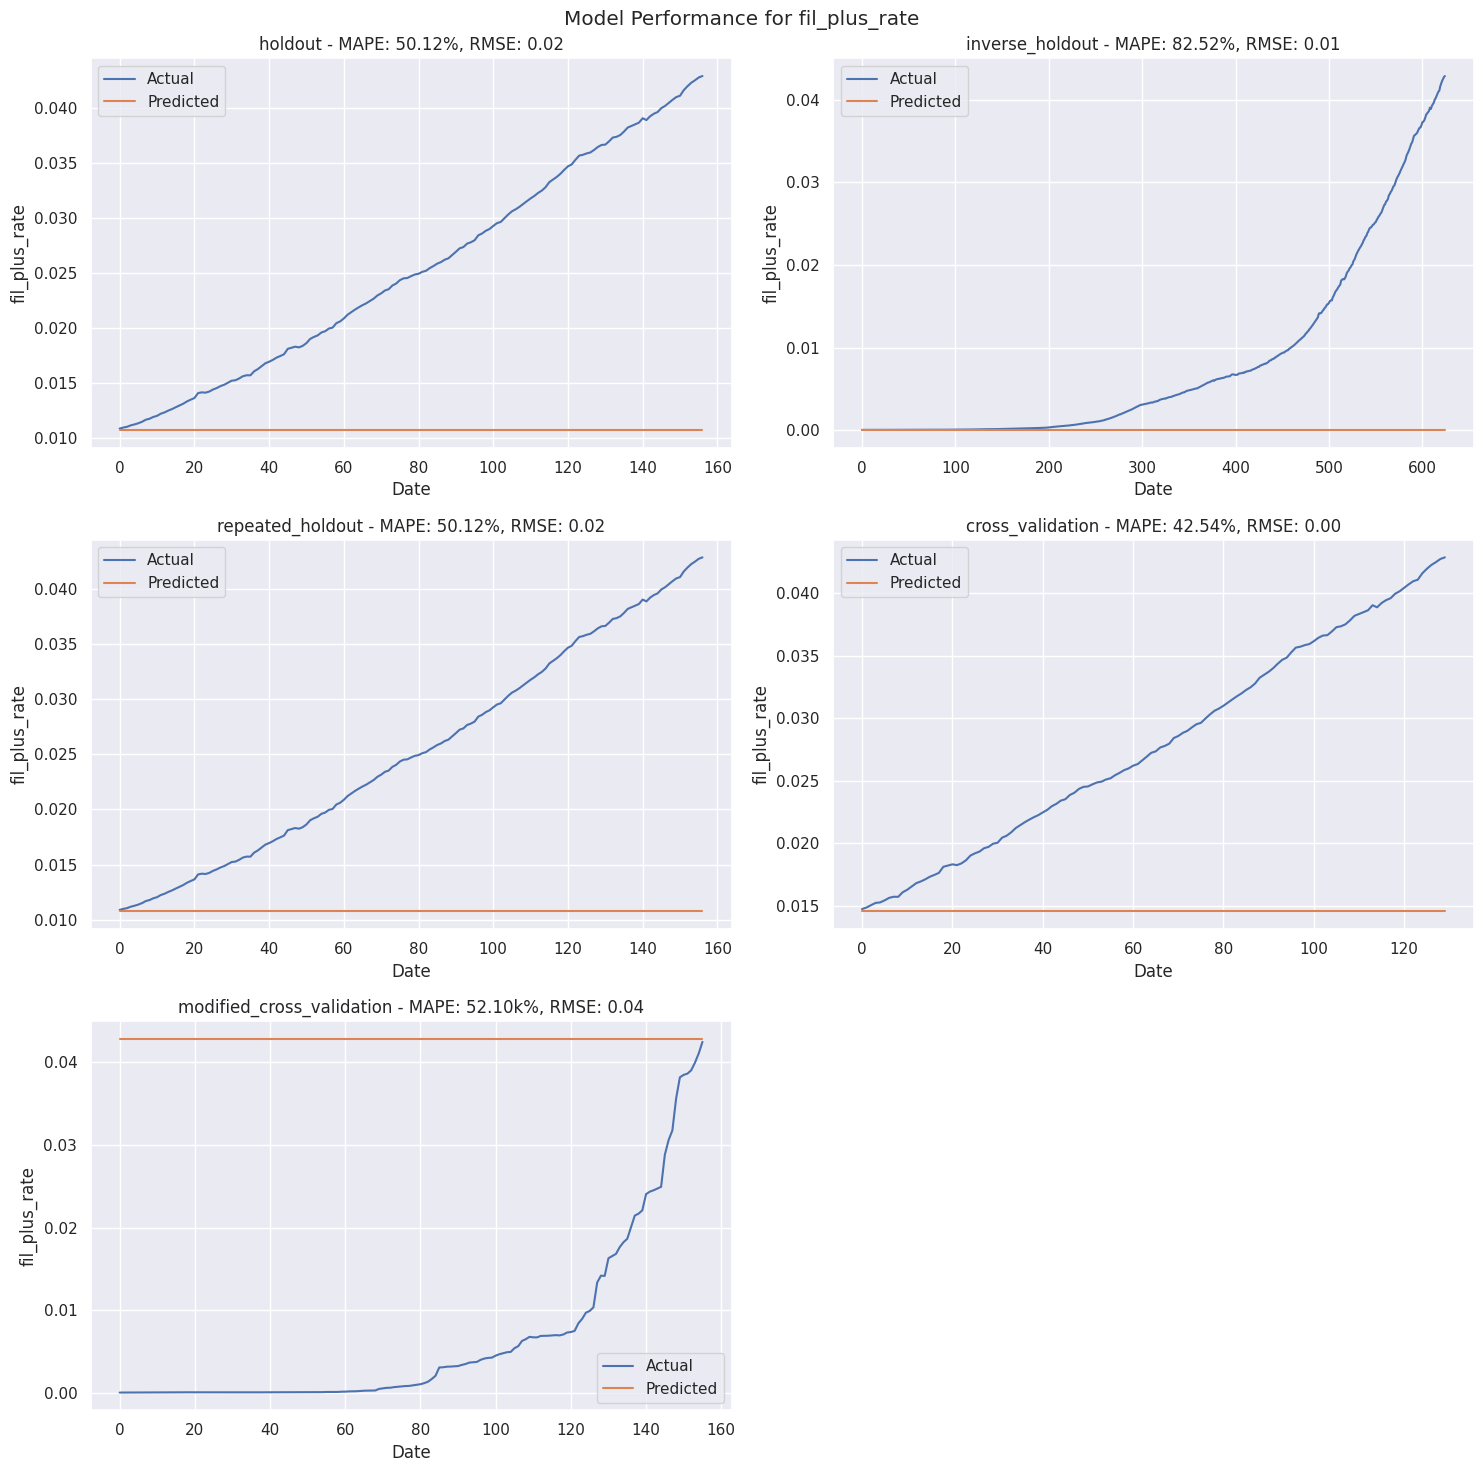

                             MAPE  RMSE
Holdout                     50.12  0.02
Inverse Holdout             82.52  0.01
Repeated Holdout            50.12  0.02
Cross-Validation            42.54  0.00
Modified Cross-Validation  52.10k  0.04


In [ ]:
# tests the performance of the Exponential Smoothing model using your function
test_performance_estimation_methods(X, y, exp_smoothing_model)

###Notes


<a class="anchor" id="smoothing_arima">
    
### 6.7 Exponential Smoothing + ARIMA
    
</a>

####**Introduction**:
In this step, Exponential Smoothing and SARIMAX, an extension of the ARIMA model that incorporates seasonality, are combined to improve time series forecasting. The main idea is to leverage the strengths of both methods to achieve better results.

Exponential Smoothing is a time series forecasting method that applies a smoothing factor to the data, giving more weight to recent observations and less weight to older ones. This approach helps to reduce noise in the data, making it easier to identify underlying patterns and trends. However, Exponential Smoothing does not explicitly model the time series components, such as seasonality and trends, which can limit its forecasting accuracy.

On the other hand, SARIMAX is a more sophisticated model that explicitly captures the time series components, such as autoregressive (AR), moving average (MA), and seasonal components. By modeling these components, SARIMAX can provide more accurate forecasts, especially for time series with complex patterns.

In the combined technique, Exponential Smoothing is first applied to the original time series to remove noise and obtain a smoothed version of the data. Then, the smoothed time series is used as input for the SARIMAX model. By doing so, the SARIMAX model's ability to capture the underlying patterns in the data is enhanced, as the noise has been reduced by the Exponential Smoothing step.

The combined approach takes advantage of the noise reduction capabilities of Exponential Smoothing and the explicit modeling of time series components by the SARIMAX model. As a result, this technique can potentially lead to improved forecasting performance compared to using either method alone

#### **Delta RBP**

In [ ]:
# defines input and output variables
y_var = 'delta_RBP'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

# Scale the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# applies Simple Exponential Smoothing to remove noise
smoothing_level = best_alpha_delta_RBP
model = SimpleExpSmoothing(y)
model_fit = model.fit(smoothing_level=smoothing_level, optimized=False)
smoothed_y = model_fit.fittedvalues

In [ ]:
# defines order and seasonal_order for SARIMAX (results from autoarima)
order = (2,1,0)
seasonal_order = (3, 1, 0, 6)

In [ ]:
# defines the SARIMAX model wrapper
class SARIMAXWrapped:
    def __init__(self, order=(0, 1, 1), seasonal_order=(3, 1, 1, 6)):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X_train, y_train):
        self.model = SARIMAX(y_train, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

# creates an instance of the SARIMAX model wrapper
sarimax_model = SARIMAXWrapped(order=order, seasonal_order= seasonal_order)

In [ ]:
# defines the combined model wrapper
class CombinedModelWrapper:
    def __init__(self, smoothing_level=0.2, sarimax_order=(0, 1, 1), sarimax_seasonal_order=(3, 1, 1, 6)):
        self.smoothing_level = smoothing_level
        self.sarimax_order = sarimax_order
        self.sarimax_seasonal_order = sarimax_seasonal_order

    def fit(self, X_train, y_train):
        # Apply Simple Exponential Smoothing to remove noise
        model = SimpleExpSmoothing(y_train)
        model_fit = model.fit(smoothing_level=self.smoothing_level, optimized=False)
        smoothed_y_train = model_fit.fittedvalues

        # Fit the SARIMAX model on the smoothed time series
        self.sarimax_model = SARIMAXWrapped(order=self.sarimax_order, seasonal_order=self.sarimax_seasonal_order)
        self.sarimax_model.fit(X_train, smoothed_y_train)
        return self

    def predict(self, X):
        return self.sarimax_model.predict(X)

# creates an instance of the combined model wrapper
combined_model = CombinedModelWrapper(smoothing_level=0.2, sarimax_order=(0, 1, 1), sarimax_seasonal_order=(3, 1, 1, 6))

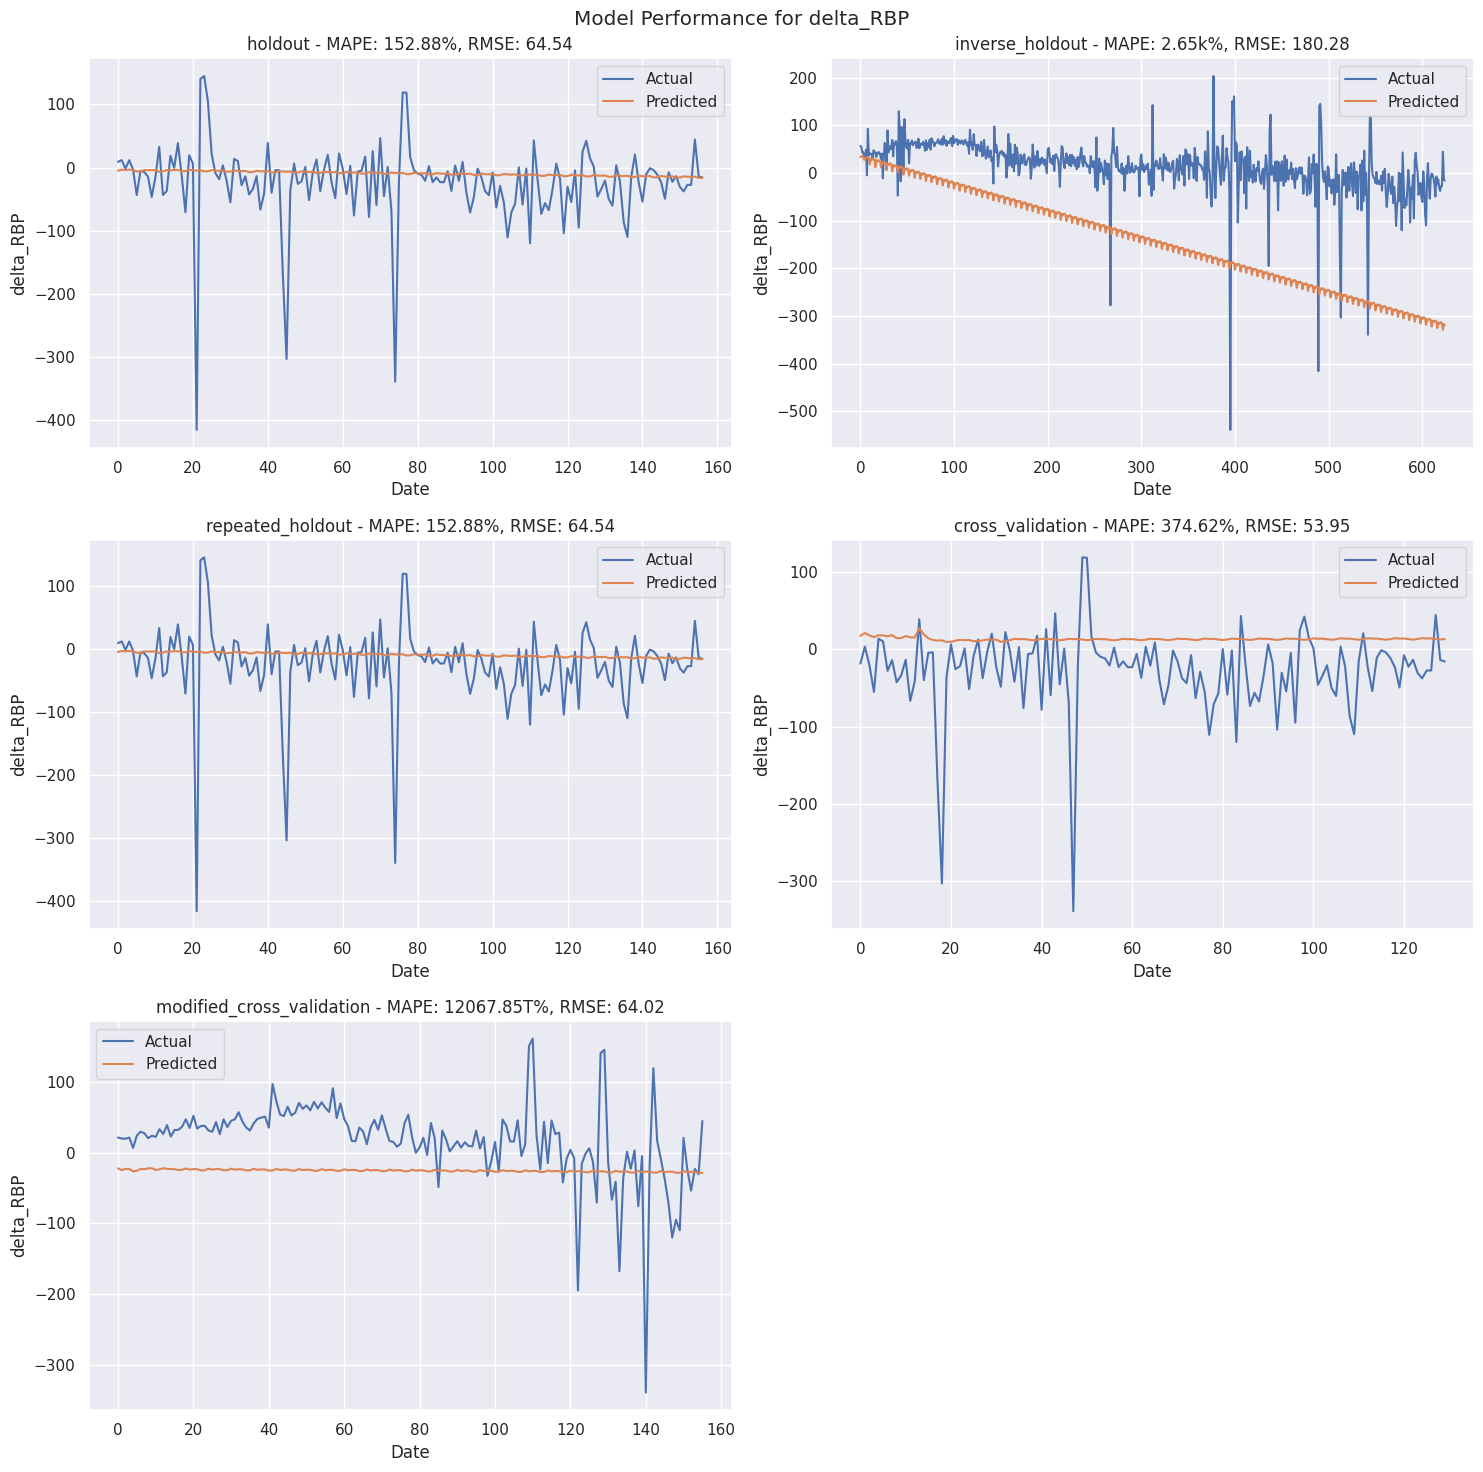

                                MAPE    RMSE
Holdout                       152.88   64.54
Inverse Holdout                2.65k  180.28
Repeated Holdout              152.88   64.54
Cross-Validation              374.62   53.95
Modified Cross-Validation  12067.85T   64.02


In [ ]:
# tests the performance of the combined model using your function
test_performance_estimation_methods(X_scaled, y, combined_model)

#### **Fil Plus Rate**

In [ ]:
# defines input and output variables
y_var = 'fil_plus_rate'
X = df_model.drop(y_var, axis=1)
y = df_model[y_var]

# Scale the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# applies Simple Exponential Smoothing to remove noise
smoothing_level = 0.2
model = SimpleExpSmoothing(y)
model_fit = model.fit(smoothing_level=smoothing_level, optimized=False)
smoothed_y = model_fit.fittedvalues

In [ ]:
#define order and seasonal order using best parameters from autoarima
order = (0,1,0)
seasonal_order = (0, 1, 3, 6)

In [ ]:
# defines the SARIMAX model wrapper
class SARIMAXWrapped:
    def __init__(self, order=(0, 1, 1), seasonal_order=(3, 1, 1, 6)):
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self, X_train, y_train):
        self.model = SARIMAX(y_train, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

# creates an instance of the SARIMAX model wrapper
sarimax_model = SARIMAXWrapped(order=order, seasonal_order= seasonal_order)

In [ ]:
# defines the combined model wrapper
class CombinedModelWrapper:
    def __init__(self, smoothing_level=0.2, sarimax_order=(0, 1, 1), sarimax_seasonal_order=(3, 1, 1, 6)):
        self.smoothing_level = smoothing_level
        self.sarimax_order = sarimax_order
        self.sarimax_seasonal_order = sarimax_seasonal_order

    def fit(self, X_train, y_train):
        # Apply Simple Exponential Smoothing to remove noise
        model = SimpleExpSmoothing(y_train)
        model_fit = model.fit(smoothing_level=self.smoothing_level, optimized=False)
        smoothed_y_train = model_fit.fittedvalues

        # Fit the SARIMAX model on the smoothed time series
        self.sarimax_model = SARIMAXWrapped(order=self.sarimax_order, seasonal_order=self.sarimax_seasonal_order)
        self.sarimax_model.fit(X_train, smoothed_y_train)
        return self

    def predict(self, X):
        return self.sarimax_model.predict(X)

# creates an instance of the combined model wrapper
combined_model = CombinedModelWrapper(smoothing_level=0.2, sarimax_order=order, sarimax_seasonal_order=seasonal_order)

In [ ]:
# tests the performance of the combined model using your function
test_performance_estimation_methods(X_scaled, y, combined_model)

                             MAPE  RMSE
Holdout                    38.31k  8.67
Inverse Holdout             84.90  0.01
Repeated Holdout           38.31k  8.67
Cross-Validation            24.87  0.00
Modified Cross-Validation  59.32k  0.06



<a class="anchor" id="feature_importance">
    
### 6.6 Feature Importance Analysis
    
</a>

#### **Delta RBP**

In [17]:
#creates a copy of df data
data_feat = data.copy()

In [19]:
# Creating a copy for applying shift on Delta_RBP
data_delta_rbp = data_feat.copy()
data_delta_rbp['shifted_delta_rbp'] = data_delta_rbp['delta_RBP'].shift()
data_delta_rbp = data_delta_rbp.dropna()

#verify dataset
data_delta_rbp

open_price  traded_volume  unique_miners       raw_byte_power  \
date                                                                        
2021-01-02   22.288815      243646888           1371  1951233466825703514   
2021-01-03   21.817991      272432560           1379  1971092158651826094   
2021-01-04   21.434067      312309245           1381  1987660012176014994   
2021-01-05   21.428017      213135095           1388  2007411467258692010   
2021-01-06   21.638214      201738931           1400  2023359471102721944   
...                ...            ...            ...                  ...   
2023-02-16    5.479461      401387749           5989 -2735280021588411262   
2023-02-17    5.398729     1539223863           5992 -2762668134681805314   
2023-02-18    7.668670      842413279           5999 -2718197081226346726   
2023-02-19    7.514821     1727690437           6000 -2731879300843175326   
2023-02-20    8.444652      906160252           6001 -2747677839825305284   

            peta_raw_power  peta_quality_power    quality_adj_power  \
date                                                                  
2021-01-02     1951.233467         1951.369219  1951369219415769126   
2021-01-03     1971.092159         1971.236994  1971236994144763880   
2021-01-04     1987.660012         1987.820845  1987820844927843944   
2021-01-05     2007.411467         2007.595646  2007595645735764356   
2021-01-06     2023.359471         2023.564110  2023564109906378698   
...                    ...                 ...                  ...   
2023-02-16    15711.464052        21643.871842  3197127768332532458   
2023-02-17    15684.075939        21649.922075  3203178001000201480   
2023-02-18    15728.546992        21743.156862  3296412788493680236   
2023-02-19    15714.864773        21760.277110  3313533036315049914   
2023-02-20    15699.066234        21757.026713  3310282639667396812   

            fil_plus_rate  delta_RBP  delta_QAP  delta_fil_plus_rate  \
date                                                                   
2021-01-02       0.000008  21.198722  21.208158         4.583422e-07   
2021-01-03       0.000008  19.858692  19.867775         4.341237e-07   
2021-01-04       0.000009  16.567854  16.583851         8.262008e-07   
2021-01-05       0.000010  19.751455  19.774801         1.203735e-06   
2021-01-06       0.000011  15.948004  15.968464         1.043211e-06   
...                   ...        ...        ...                  ...   
2023-02-16       0.041954 -27.385158  12.888898         3.573201e-04   
2023-02-17       0.042264 -27.388113   6.050233         3.101495e-04   
2023-02-18       0.042489  44.471053  93.234787         2.249838e-04   
2023-02-19       0.042744 -13.682220  17.120248         2.547804e-04   
2023-02-20       0.042876 -15.798539  -3.250397         1.318249e-04   

            delta_miners  shifted_delta_rbp  
date                                         
2021-01-02           8.0           0.000000  
2021-01-03           8.0          21.198722  
2021-01-04           2.0          19.858692  
2021-01-05           7.0          16.567854  
2021-01-06          12.0          19.751455  
...                  ...                ...  
2023-02-16           5.0         -37.616938  
2023-02-17           3.0         -27.385158  
2023-02-18           7.0         -27.388113  
2023-02-19           1.0          44.471053  
2023-02-20           1.0         -13.682220  

[780 rows x 13 columns]

## `Permutation Importance`

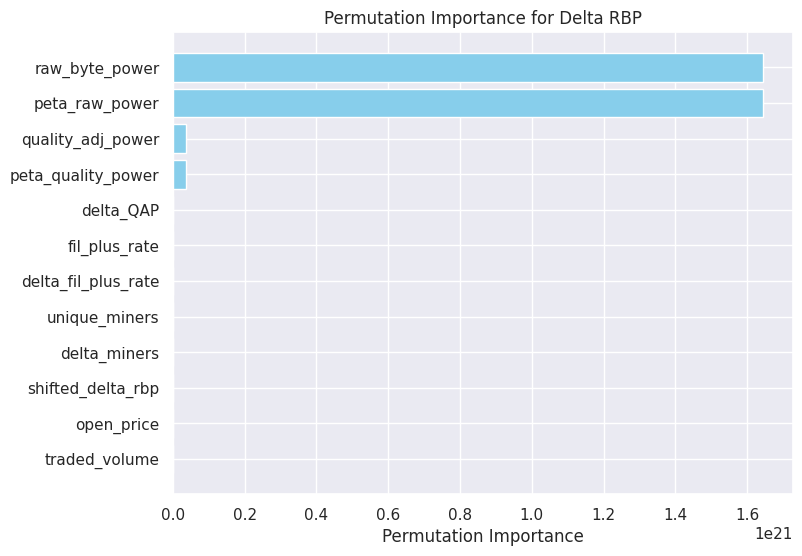

In [26]:
from sklearn.metrics import mean_squared_error

# Assuming 'data_delta_rbp' is your dataset with features and 'actual_delta_rbp' is the shifted target variable

# Define input and output variables
X = data_delta_rbp.drop(['delta_RBP'], axis=1)
y = data_delta_rbp['delta_RBP']  # 'delta_RBP' is the target variable

# Scale the input data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Transform scaled data back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lr_model.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred)

# Calculate permutation feature importance
result = permutation_importance(lr_model, X_test, y_test, n_repeats=50, random_state=0)

# Get the feature importance scores
importance = result.importances_mean

# Get feature names
feature_names = X.columns

# Create a sorted index based on importance
sorted_idx = importance.argsort()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.barh(feature_names[sorted_idx], importance[sorted_idx], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance for Delta RBP')
plt.show()


## `SHAP (SHapley Additive exPlanations)`

In [30]:
# Assuming 'data_delta_rbp' is your dataset with features and 'actual_delta_rbp' is the shifted target variable

# Define input and output variables
X = data_delta_rbp.drop(['delta_RBP'], axis=1)
y = data_delta_rbp['delta_RBP']  # 'delta_RBP' is the target variable

# Scale the input data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Transform scaled data back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Create a callable function for the model prediction
model_predict = lr_model.predict

# Create an explainer object
explainer = shap.Explainer(model_predict, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False) #plot_type="bar"
plt.title("SHAP Values for Delta_RBP")
plt.show()



PermutationExplainer explainer: 157it [00:10,  1.05it/s]                         


#### **Fil Plus Rate**


In [27]:
# Creating a copy for applying shift on Delta_RBP
data_fil_plus = data_feat.copy()
data_fil_plus['shifted_fil_plus_rate'] = data_fil_plus['fil_plus_rate'].shift()
data_fil_plus = data_fil_plus.dropna()

#verify dataset
data_fil_plus

open_price  traded_volume  unique_miners       raw_byte_power  \
date                                                                        
2021-01-02   22.288815      243646888           1371  1951233466825703514   
2021-01-03   21.817991      272432560           1379  1971092158651826094   
2021-01-04   21.434067      312309245           1381  1987660012176014994   
2021-01-05   21.428017      213135095           1388  2007411467258692010   
2021-01-06   21.638214      201738931           1400  2023359471102721944   
...                ...            ...            ...                  ...   
2023-02-16    5.479461      401387749           5989 -2735280021588411262   
2023-02-17    5.398729     1539223863           5992 -2762668134681805314   
2023-02-18    7.668670      842413279           5999 -2718197081226346726   
2023-02-19    7.514821     1727690437           6000 -2731879300843175326   
2023-02-20    8.444652      906160252           6001 -2747677839825305284   

            peta_raw_power  peta_quality_power    quality_adj_power  \
date                                                                  
2021-01-02     1951.233467         1951.369219  1951369219415769126   
2021-01-03     1971.092159         1971.236994  1971236994144763880   
2021-01-04     1987.660012         1987.820845  1987820844927843944   
2021-01-05     2007.411467         2007.595646  2007595645735764356   
2021-01-06     2023.359471         2023.564110  2023564109906378698   
...                    ...                 ...                  ...   
2023-02-16    15711.464052        21643.871842  3197127768332532458   
2023-02-17    15684.075939        21649.922075  3203178001000201480   
2023-02-18    15728.546992        21743.156862  3296412788493680236   
2023-02-19    15714.864773        21760.277110  3313533036315049914   
2023-02-20    15699.066234        21757.026713  3310282639667396812   

            fil_plus_rate  delta_RBP  delta_QAP  delta_fil_plus_rate  \
date                                                                   
2021-01-02       0.000008  21.198722  21.208158         4.583422e-07   
2021-01-03       0.000008  19.858692  19.867775         4.341237e-07   
2021-01-04       0.000009  16.567854  16.583851         8.262008e-07   
2021-01-05       0.000010  19.751455  19.774801         1.203735e-06   
2021-01-06       0.000011  15.948004  15.968464         1.043211e-06   
...                   ...        ...        ...                  ...   
2023-02-16       0.041954 -27.385158  12.888898         3.573201e-04   
2023-02-17       0.042264 -27.388113   6.050233         3.101495e-04   
2023-02-18       0.042489  44.471053  93.234787         2.249838e-04   
2023-02-19       0.042744 -13.682220  17.120248         2.547804e-04   
2023-02-20       0.042876 -15.798539  -3.250397         1.318249e-04   

            delta_miners  shifted_fil_plus_rate  
date                                             
2021-01-02           8.0               0.000007  
2021-01-03           8.0               0.000008  
2021-01-04           2.0               0.000008  
2021-01-05           7.0               0.000009  
2021-01-06          12.0               0.000010  
...                  ...                    ...  
2023-02-16           5.0               0.041597  
2023-02-17           3.0               0.041954  
2023-02-18           7.0               0.042264  
2023-02-19           1.0               0.042489  
2023-02-20           1.0               0.042744  

[780 rows x 13 columns]

## `Permutation Importance`



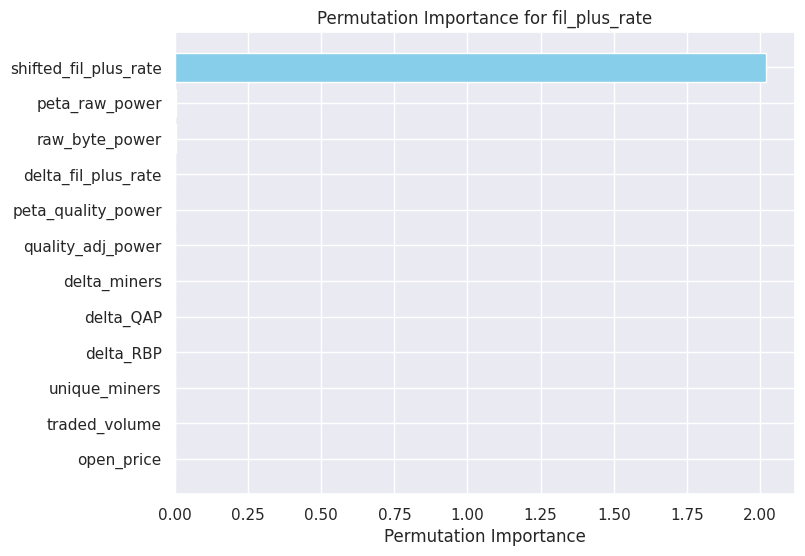

In [28]:
from sklearn.metrics import mean_squared_error

# Assuming 'data_fil_plus' is your dataset with features and 'shifted_fil_plus_rate' is the shifted target variable

# Define input and output variables
X = data_fil_plus.drop(['fil_plus_rate'], axis=1)
y = data_fil_plus['fil_plus_rate']  # 'fil_plus_rate' is the target variable

# Scale the input data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Transform scaled data back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Create a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = lr_model.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred)

# Calculate permutation feature importance
result = permutation_importance(lr_model, X_test, y_test, n_repeats=50, random_state=0)

# Get the feature importance scores
importance = result.importances_mean

# Get feature names
feature_names = X.columns

# Create a sorted index based on importance
sorted_idx = importance.argsort()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.barh(feature_names[sorted_idx], importance[sorted_idx], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance for fil_plus_rate')
plt.show()


## `SHAP (SHapley Additive exPlanations)`

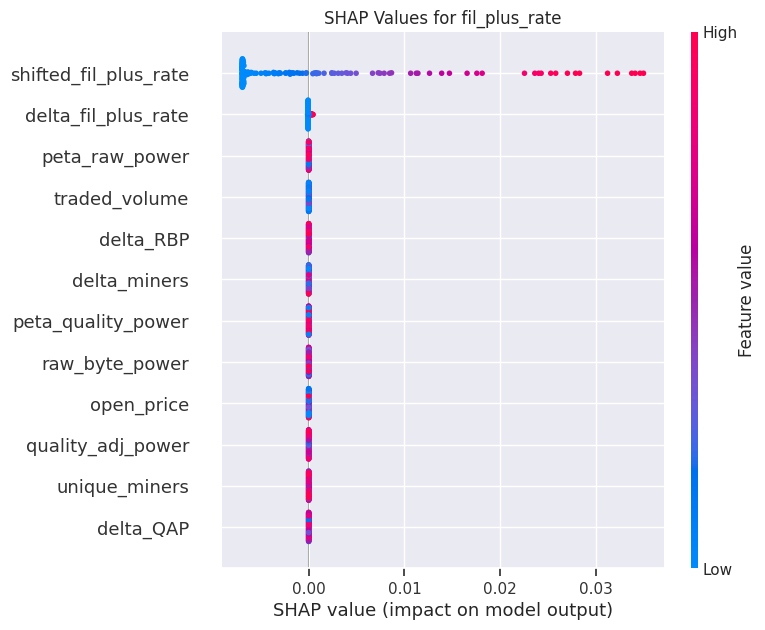

In [32]:
# Assuming 'data_fil_plus' is your dataset with features and 'shifted_fil_plus_rate' is the shifted target variable

# Define input and output variables
X = data_fil_plus.drop(['fil_plus_rate'], axis=1)
y = data_fil_plus['fil_plus_rate']  # 'fil_plus_rate' is the target variable

# Scale the input data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Transform scaled data back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Create a callable function for the model prediction
model_predict = lr_model.predict

# Create an explainer object
explainer = shap.Explainer(model_predict, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns,  show=False)
plt.title("SHAP Values for fil_plus_rate")
plt.show()





> ## END!

